In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import rankdata, pearsonr, spearmanr
import upsetplot
from IPython.display import display
from itertools import combinations
from statsmodels.stats.multitest import multipletests

In [3]:
def process_df(df:pd.DataFrame, drop_APOE:bool=True):
    summ_df = df.copy()
    summ_df['Gene'] = summ_df['Gene'].apply(lambda x: x.split('_')[0]).values
    summ_df.sort_values(['Gene', 'Acc'], ascending=[True, False], inplace=True)
    summ_df.drop_duplicates('Gene', inplace=True)
    if drop_APOE:
        summ_df = summ_df.loc[~summ_df['Gene'].isin(['APOE', 'TOMM40', 'APOC1', 'BCAM'])]
    if 'P' in df.columns:
        summ_df['-logP'] = -np.log10(summ_df['P'])
        summ_df['Rank'] = rankdata(summ_df['P'])
    return summ_df

## Sensitivity vs GWANNv1

In [33]:
for s in ['1.4']:
# for s in ['1.3', '1.4', '1.5', '1.6']:
    if s != '1.4':
        summ_df_new = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_Sens{s}/MATERNAL_MARIONI_Sens{s}_summary.csv')
    else:
        summ_df_new = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_Sens{s}/1_MATERNAL_MARIONI_Sens{s}_summary.csv')
    summ_df_new = process_df(summ_df_new)
    summ_df_v1 = pd.read_csv('../../GWASOnSteroids/Results/Annotated_NoDup_MatAD_NN_GWAS.csv')
    summ_df_v1 = process_df(summ_df_v1)
    summ_df_v1.set_index('Gene', inplace=True, drop=False)
    summ_df_v1 = summ_df_v1.loc[summ_df_new['Gene'].values]

    x = summ_df_new[f'{metric}'].values
    y = summ_df_v1[f'{metric}'].values
    sns.regplot(x=x, y=y, ci=None)
    if metric == '-logP':
        plt.axvline(x=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
        plt.axhline(y=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
    plt.xlabel(f'{metric} when using dosage (Sens{s})')
    plt.ylabel(f'{metric} when using hardcall (-1 as missing)')
    plt.savefig(f'./results_Sens{s}/dosage_vs_hardcall_{metric}.png', dpi=100)
    plt.close()

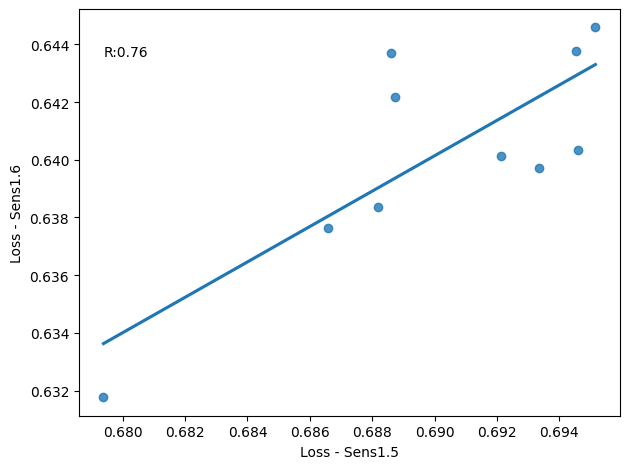

In [55]:
a = 'Sens1.5'
b = 'Sens1.6'
summ_df_a = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_{a}/MATERNAL_MARIONI_{a}_summary.csv')
summ_df_a = process_df(summ_df_a)

summ_df_b = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_{b}/MATERNAL_MARIONI_{b}_summary.csv')
summ_df_b = process_df(summ_df_b)
summ_df_b.set_index('Gene', inplace=True, drop=False)
summ_df_b = summ_df_b.loc[summ_df_a['Gene']]

x = summ_df_a[f'{metric}'].values
y = summ_df_b[f'{metric}'].values
r, p = spearmanr(x, y)
sns.regplot(x=x, y=y, ci=False)
plt.text(x=np.min(x), y=np.max(y)-0.001, s=f'R:{r:.2f}')
if metric == '-logP':
    plt.axvline(x=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
    plt.axhline(y=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
plt.xlabel(f'{metric} - {a}')
plt.ylabel(f'{metric} - {b}')

plt.tight_layout()
plt.savefig(f'./results_{a}/{a}_vs_{b}_{metric}.png', dpi=100)


## Sens 1.4

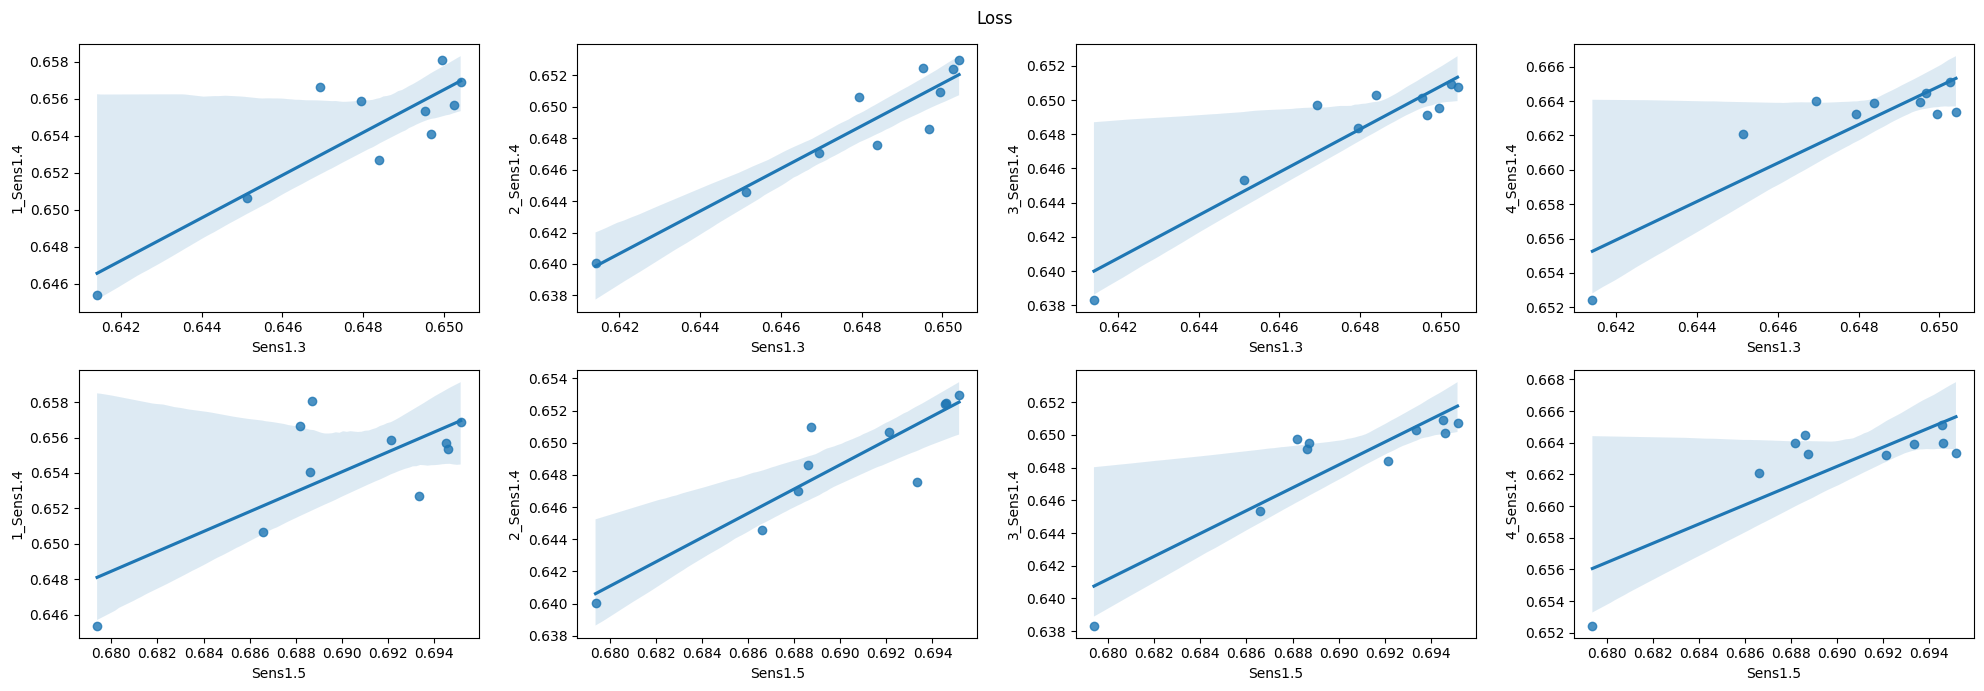

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(20, 7))
ax = ax.flatten()
axi = 0
for sens in ['Sens1.3', 'Sens1.5']:
    for grouping in [1, 2, 3, 4]:
        summ_df_14 = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_Sens1.4/{grouping}_MATERNAL_MARIONI_Sens1.4_summary.csv')
        summ_df_14 = process_df(summ_df_14)
        summ_df_1x = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_{sens}/MATERNAL_MARIONI_{sens}_summary.csv')
        summ_df_1x = process_df(summ_df_1x)
        summ_df_1x.set_index('Gene', inplace=True, drop=False)
        summ_df_1x = summ_df_1x.loc[summ_df_14['Gene']]

        x = summ_df_1x[f'{metric}'].values
        y = summ_df_14[f'{metric}'].values
        # sns.scatterplot(x=x, y=y, ax=ax[axi])
        sns.regplot(x=x, y=y, ax=ax[axi])
        if metric == '-logP':
            ax[axi].axvline(x=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
            ax[axi].axhline(y=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
        ax[axi].set_xlabel(f'{sens}')
        ax[axi].set_ylabel(f'{grouping}_Sens1.4')
        
        axi += 1

fig.suptitle(metric)
fig.tight_layout()
fig.savefig(f'./results_Sens1.4/Sens1.4_vs_Sens1x_{metric}.png', dpi=100)


In [26]:
agg_summ_df = pd.DataFrame(columns=['Gene', 'Acc', 'Loss', '-logP', 'Rank', 'Grouping_id'])
for i in range(1, 5):
    for j in range(i+1, 5):
        dfi = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_Sens1.4/{i}_MATERNAL_MARIONI_Sens1.4_summary.csv')
        dfi = process_df(dfi)
        dfj = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_Sens1.4/{j}_MATERNAL_MARIONI_Sens1.4_summary.csv')
        dfj = process_df(dfj)
        
        x = dfi[f'{metric}'].values
        y = dfj[f'{metric}'].values

        sns.regplot(x=x, y=y)
        if metric == '-logP':
            plt.axvline(x=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
            plt.axhline(y=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
        plt.savefig(f'./results_Sens1.4/effect_of_diff_grouping/{i}vs{j}_{metric}.png', dpi=100)
        plt.close()


## Sens2

In [55]:
grp_sizes = [5, 10, 15, 20]
rand_seeds = [82, 192, 8376, 1763]
for label in ['MATERNAL_MARIONI']:
    grp_summ_df = []
    for grp_size in grp_sizes:
        for si, seed in enumerate(rand_seeds):
            exp_name = f'Sens2_{si}_{grp_size}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            summ_df = pd.read_csv(exp_summ_path)
            summ_df = process_df(summ_df)
            summ_df['Group_size'] = grp_size
            summ_df['Random_seed'] = seed
            summ_df = summ_df[['Group_size', 'Random_seed', 'Gene', 'Acc', 'Loss']]
            grp_summ_df.append(summ_df)
    grp_summ_df = pd.concat(grp_summ_df)

In [56]:
for met in ['Loss', 'Acc']:
    sns.displot(data=grp_summ_df, col='Group_size', x=met, hue='Random_seed', 
                kind='kde', palette='flare', hue_order=rand_seeds)
    plt.savefig(f'./results_Sens2/Diff_groupings_{met}.png', dpi=100)
    plt.close()

In [57]:
metric = 'Acc'
for grp_size in grp_sizes:
    fig, ax = plt.subplots(3, 3, figsize=(15, 10))
    for j in range(len(rand_seeds)):
        exp_name = f'Sens2_{j}_{grp_size}'
        exp_summ_path = (f'NN_Logs/'+
            f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
            f'{label}_Chr{exp_name}_2500bp_summary.csv')
        dfj = pd.read_csv(exp_summ_path)
        dfj = process_df(dfj)

        for k in range(j+1, len(rand_seeds)):
            exp_name = f'Sens2_{k}_{grp_size}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            dfk = pd.read_csv(exp_summ_path)
            dfk = process_df(dfk)

            x = dfj[metric].values
            y = dfk[metric].values
            r, p = spearmanr(x, y)
            sns.regplot(x=x, y=y, ci=False, ax=ax[k-1][j])
            # ax[k-1][j].text(x=0.5, y=0.5, s=f'R:{r}\nP:{p}')
            ax[k-1][j].text(x=np.min(x), y=np.max(y)-0.001, s=f'R:{r:.2f}')

    fig.tight_layout()
    fig.savefig(f'./results_Sens2/Grp_size{grp_size}_{metric}.png', dpi=100)
    plt.close()


## Sens3

In [73]:
grp_sizes = [5, 10, 15, 20, 25, 30]
sens_types = ['Sens2', 'Sens2', 'Sens2', 'Sens3', 'Sens3', 'Sens3']
rand_seeds = [82, 192, 8376, 1763]

In [74]:
for label in ['MATERNAL_MARIONI']:
    grp_summ_df = []
    for sens_type, grp_size in zip(sens_types, grp_sizes):
        for si, seed in enumerate(rand_seeds):
            exp_name = f'{sens_type}_{si}_{grp_size}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            summ_df = pd.read_csv(exp_summ_path)
            summ_df = process_df(summ_df)
            summ_df['Group_size'] = grp_size
            summ_df['Random_seed'] = seed
            summ_df = summ_df[['Group_size', 'Random_seed', 'Gene', 'Acc', 'Loss']]
            grp_summ_df.append(summ_df)
    grp_summ_df = pd.concat(grp_summ_df)

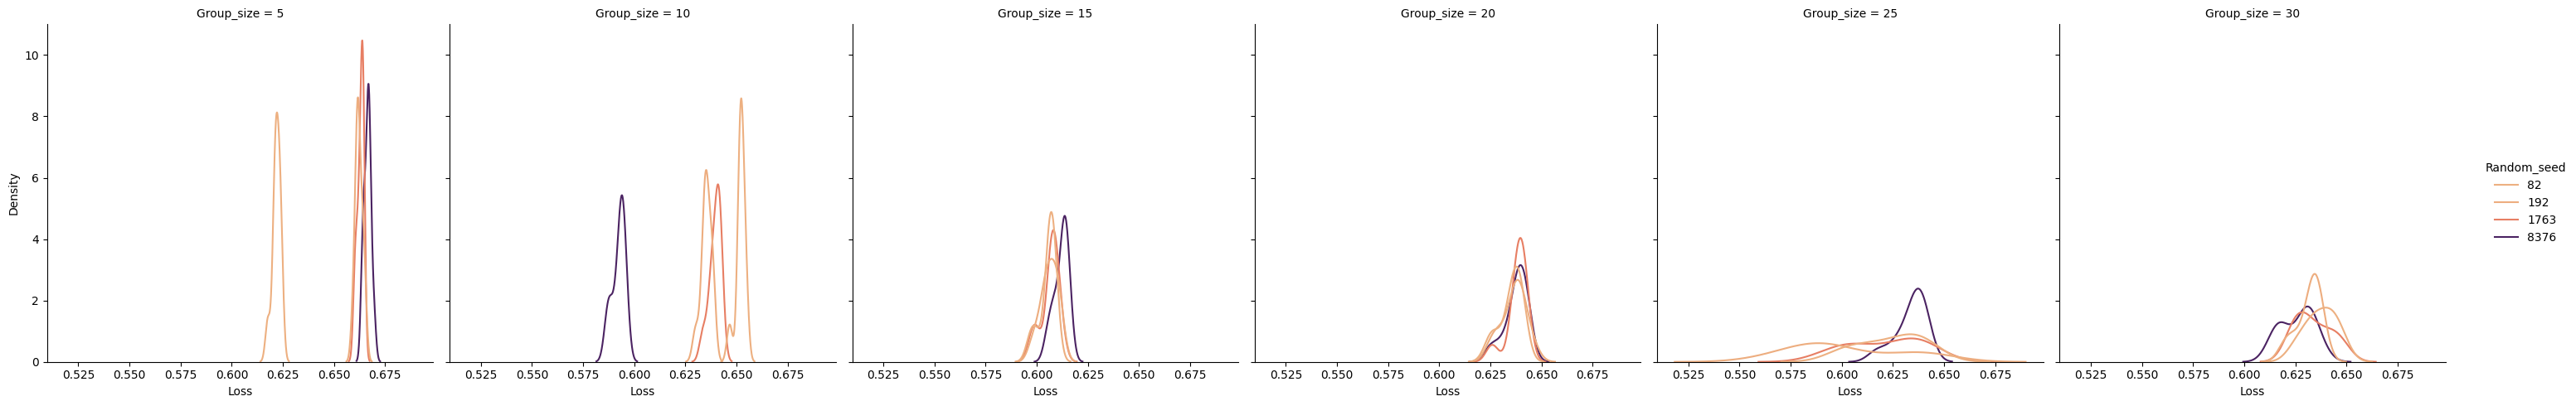

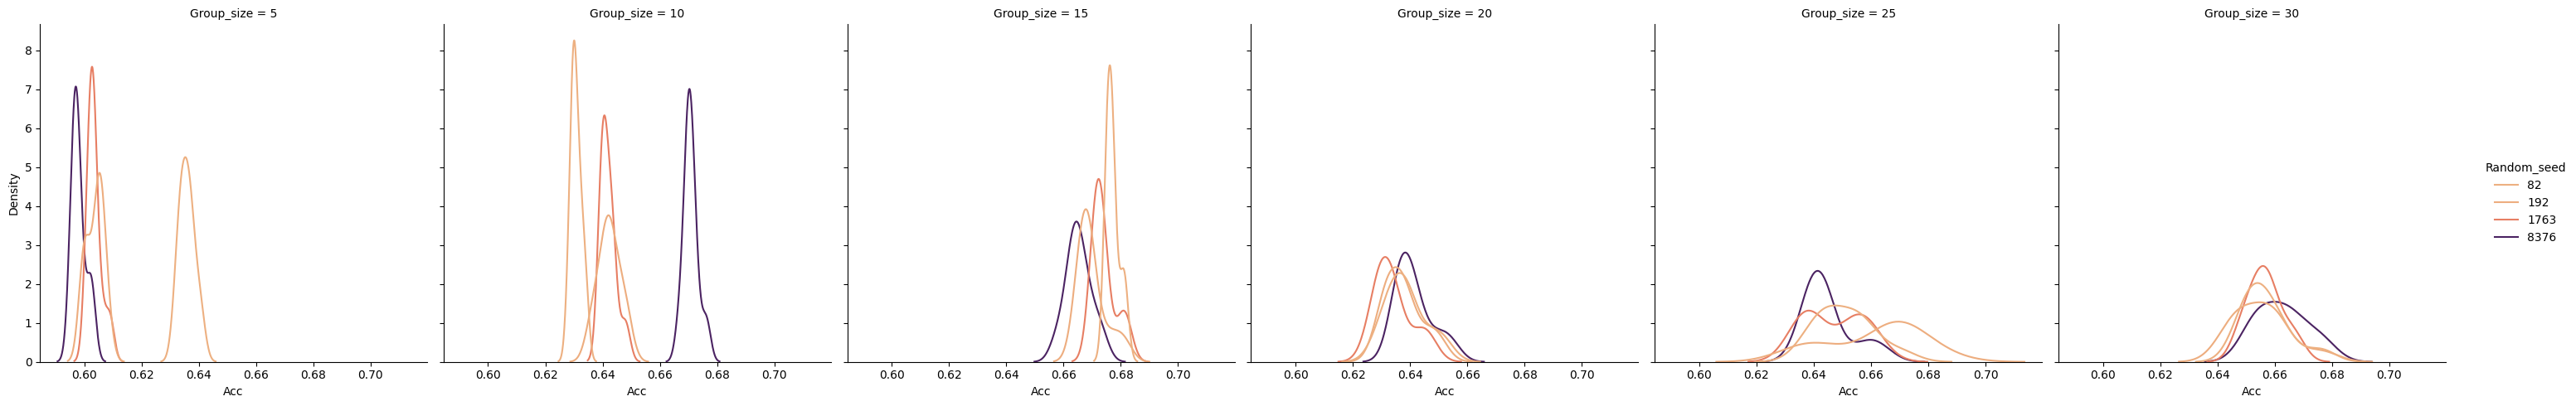

In [76]:
for met in ['Loss', 'Acc']:
    sns.displot(data=grp_summ_df, col='Group_size', x=met, hue='Random_seed', 
                kind='kde', palette='flare', hue_order=rand_seeds)
    plt.savefig(f'./results_Sens3/Diff_groupings_{met}.png', dpi=100)

In [77]:
corr_fn = pearsonr
corr_dict = {'Group_size':[], 'Rand_seed_pair':[], corr_fn.__name__:[], 'Metric':[]}
for sens_type, grp_size in zip(sens_types, grp_sizes):
    for j in range(len(rand_seeds)):
        exp_name = f'{sens_type}_{j}_{grp_size}'
        exp_summ_path = (f'NN_Logs/'+
            f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
            f'{label}_Chr{exp_name}_2500bp_summary.csv')
        dfj = pd.read_csv(exp_summ_path)
        dfj = process_df(dfj)

        for k in range(j+1, len(rand_seeds)):
            exp_name = f'{sens_type}_{k}_{grp_size}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            dfk = pd.read_csv(exp_summ_path)
            dfk = process_df(dfk)

            for metric in ['Acc', 'Loss']:
                x = dfj[metric].values
                y = dfk[metric].values
                r, p = corr_fn(x, y)
                corr_dict['Group_size'].append(grp_size)
                corr_dict['Rand_seed_pair'].append(f'{j}_{k}')
                corr_dict[corr_fn.__name__].append(r)
                corr_dict['Metric'].append(metric)
corr_df = pd.DataFrame.from_dict(corr_dict)


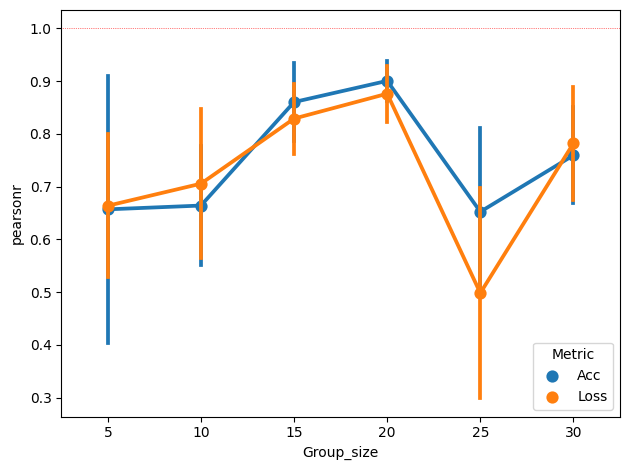

In [78]:
sns.pointplot(data=corr_df, x='Group_size', y=corr_fn.__name__, hue='Metric', 
              errorbar='sd')
plt.axhline(y=1, xmin=0, xmax=1, linestyle=':', c='r', linewidth='0.5')
plt.tight_layout()
plt.savefig(f'./results_Sens3/Diff_groupings_{corr_fn.__name__}.png', dpi=100)

## Sens4

In [40]:
oversample = [5, 10, 15, 20]
sens_types = ['Sens4', 'Sens4', 'Sens4', 'Sens3']
rand_seeds = [82, 192, 8376, 1763]
grp_size = 20

In [41]:
for label in ['MATERNAL_MARIONI']:
    grp_summ_df = []
    for sens_type, ovs in zip(sens_types, oversample):
        for si, seed in enumerate(rand_seeds):
            exp_name = f'{sens_type}_{si}_{ovs}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            summ_df = pd.read_csv(exp_summ_path)
            summ_df = process_df(summ_df)
            summ_df['Group_size'] = grp_size
            summ_df['Oversample'] = ovs
            summ_df['Random_seed'] = seed
            summ_df = summ_df[['Group_size', 'Oversample', 'Random_seed', 'Gene', 'Acc', 'Loss']]
            grp_summ_df.append(summ_df)
    grp_summ_df = pd.concat(grp_summ_df)

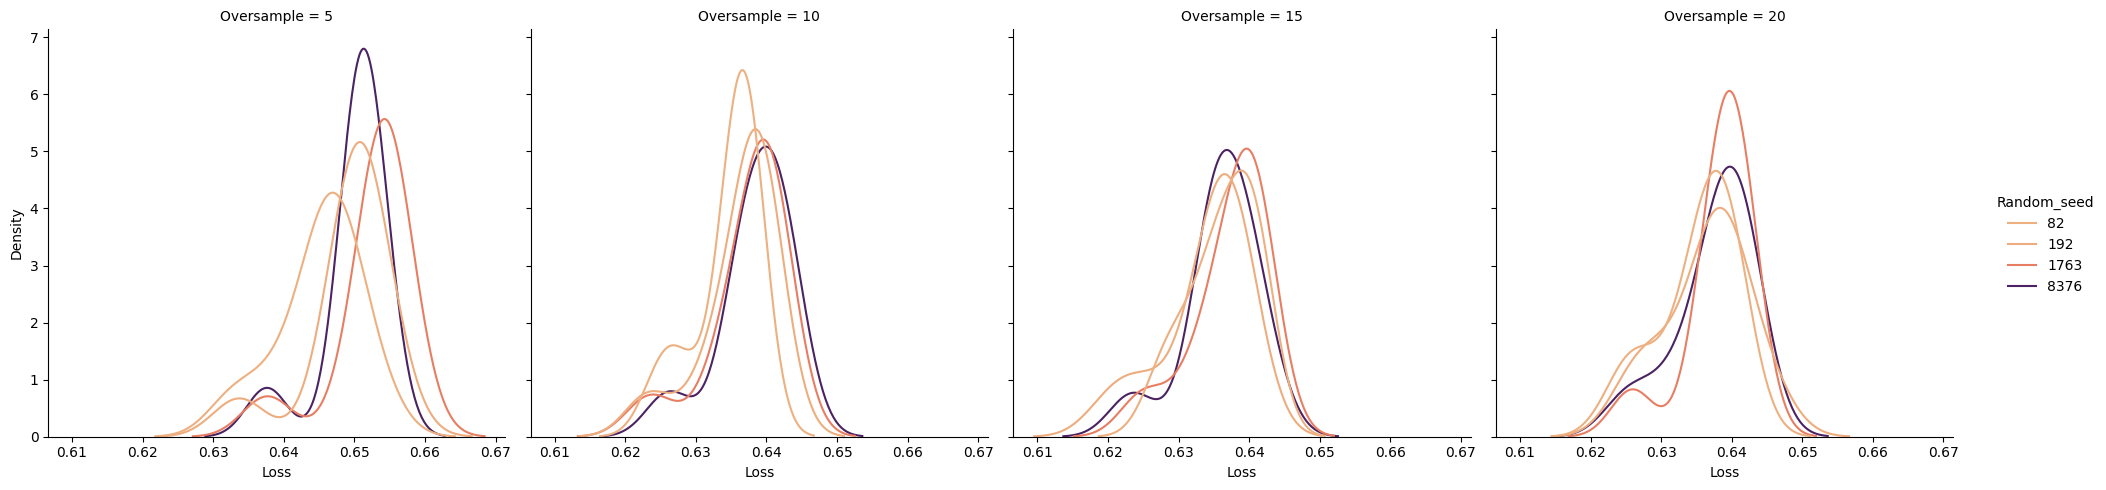

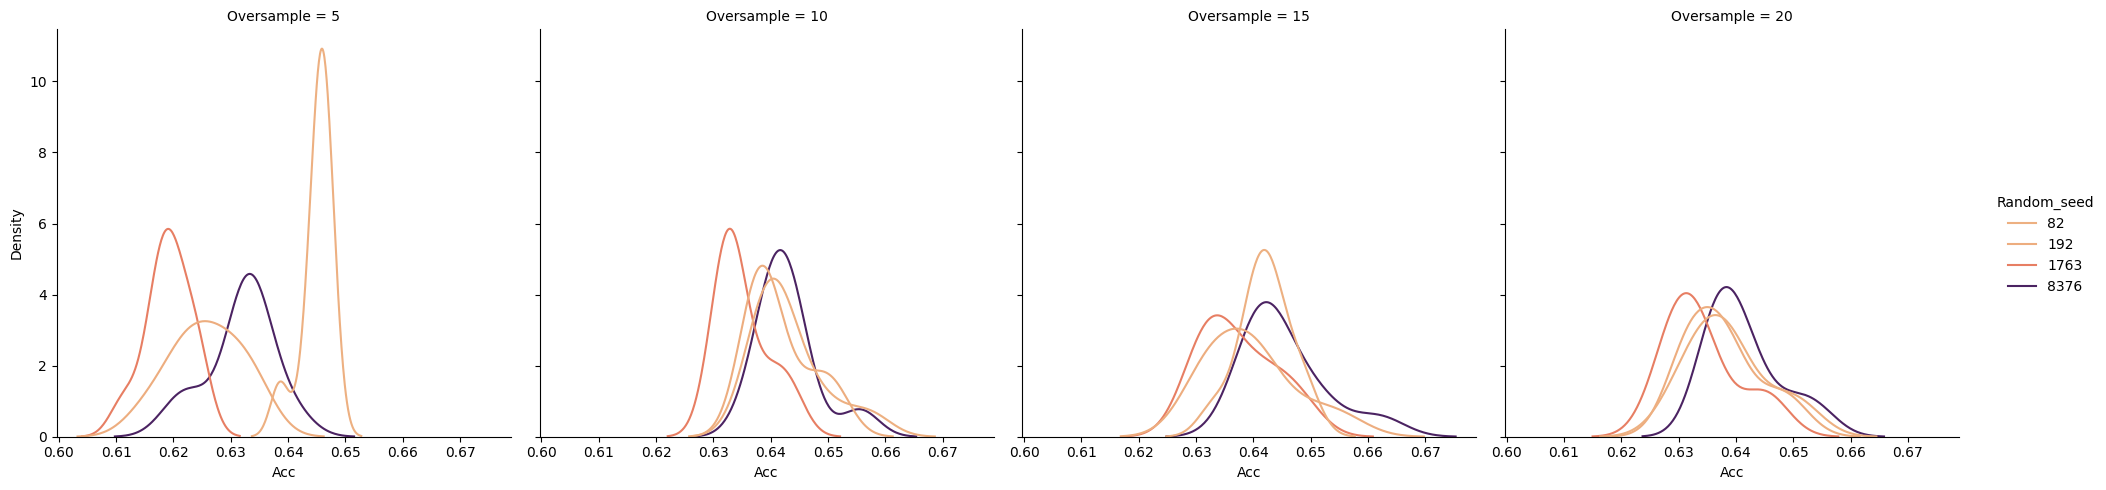

In [42]:
for met in ['Loss', 'Acc']:
    sns.displot(data=grp_summ_df, col='Oversample', x=met, hue='Random_seed', 
                kind='kde', palette='flare', hue_order=rand_seeds)
    plt.savefig(f'./results_Sens4/Diff_groupings_{met}.png', dpi=100)

In [43]:
corr_fn = spearmanr
corr_dict = {'Oversample':[], 'Rand_seed_pair':[], corr_fn.__name__:[], 'Metric':[]}
for sens_type, ovs in zip(sens_types, oversample):
    for j in range(len(rand_seeds)):
        exp_name = f'{sens_type}_{j}_{ovs}'
        exp_summ_path = (f'NN_Logs/'+
            f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
            f'{label}_Chr{exp_name}_2500bp_summary.csv')
        dfj = pd.read_csv(exp_summ_path)
        dfj = process_df(dfj)

        for k in range(j+1, len(rand_seeds)):
            exp_name = f'{sens_type}_{k}_{ovs}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            dfk = pd.read_csv(exp_summ_path)
            dfk = process_df(dfk)

            for metric in ['Acc', 'Loss']:
                x = dfj[metric].values
                y = dfk[metric].values
                r, p = corr_fn(x, y)
                corr_dict['Oversample'].append(ovs)
                corr_dict['Rand_seed_pair'].append(f'{j}_{k}')
                corr_dict[corr_fn.__name__].append(r)
                corr_dict['Metric'].append(metric)
corr_df = pd.DataFrame.from_dict(corr_dict)


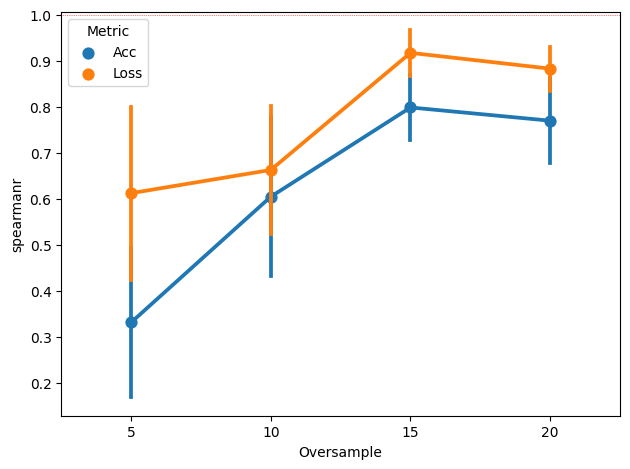

In [44]:
sns.pointplot(data=corr_df, x='Oversample', y=corr_fn.__name__, hue='Metric', 
              errorbar='sd')
plt.axhline(y=1, xmin=0, xmax=1, linestyle=':', c='r', linewidth='0.5')
plt.tight_layout()
plt.savefig(f'./results_Sens4/Diff_groupings_{corr_fn.__name__}.png', dpi=100)

### Effect of balancing batches 1:1 case:control

In [10]:
oversample = [10, 15]
batches = {'Sens4':'random', 'Sens4.1':'balanced'}
rand_seeds = [82, 192, 8376, 1763]
grp_size = 20
corr_fn = pearsonr
corr_dict = {'Rand_seed':[], corr_fn.__name__:[], 'Metric':[]}
label = 'MATERNAL_MARIONI'

for ovs in oversample:
    for j in range(len(rand_seeds)):
        exp_name = f'Sens4_{j}_{ovs}'
        exp_summ_path = (f'NN_Logs/'+
            f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
            f'{label}_Chr{exp_name}_2500bp_summary.csv')
        dfj = pd.read_csv(exp_summ_path)
        dfj = process_df(dfj)

        exp_name = f'Sens4.1_{j}_{ovs}'
        exp_summ_path = (f'NN_Logs/'+
            f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
            f'{label}_Chr{exp_name}_2500bp_summary.csv')
        dfk = pd.read_csv(exp_summ_path)
        dfk = process_df(dfk)

        for metric in ['Acc', 'Loss']:
            x = dfj[metric].values
            y = dfk[metric].values
            r, p = corr_fn(x, y)
            corr_dict['Rand_seed'].append(j)
            corr_dict[corr_fn.__name__].append(r)
            corr_dict['Metric'].append(metric)
corr_df = pd.DataFrame.from_dict(corr_dict)


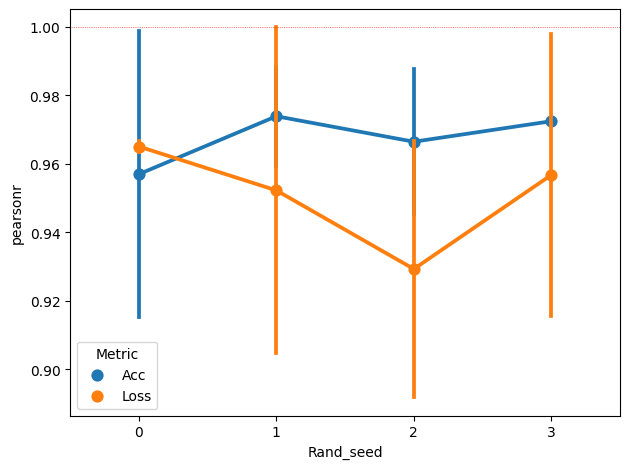

In [11]:
sns.pointplot(data=corr_df, x='Rand_seed', y=corr_fn.__name__, hue='Metric', 
              errorbar='sd')
plt.axhline(y=1, xmin=0, xmax=1, linestyle=':', c='r', linewidth='0.5')
plt.tight_layout()
plt.savefig(f'./results_Sens4/Diff_batch_type_{corr_fn.__name__}.png', dpi=100)

## Sens5

In [94]:
oversample = [15, 20]
sens_types = ['Sens5', 'Sens5']
rand_seeds = [82, 192, 8376, 1763]
grp_size = 20

In [95]:
for label in ['MATERNAL_MARIONI']:
    grp_summ_df = []
    for sens_type, ovs in zip(sens_types, oversample):
        for si, seed in enumerate(rand_seeds):
            exp_name = f'{sens_type}_{si}_{ovs}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            summ_df = pd.read_csv(exp_summ_path)
            summ_df = process_df(summ_df)
            summ_df['Group_size'] = grp_size
            summ_df['Oversample'] = ovs
            summ_df['Random_seed'] = seed
            summ_df = summ_df[['Group_size', 'Oversample', 'Random_seed', 'Gene', 'Acc', 'Loss']]
            grp_summ_df.append(summ_df)
    grp_summ_df = pd.concat(grp_summ_df)

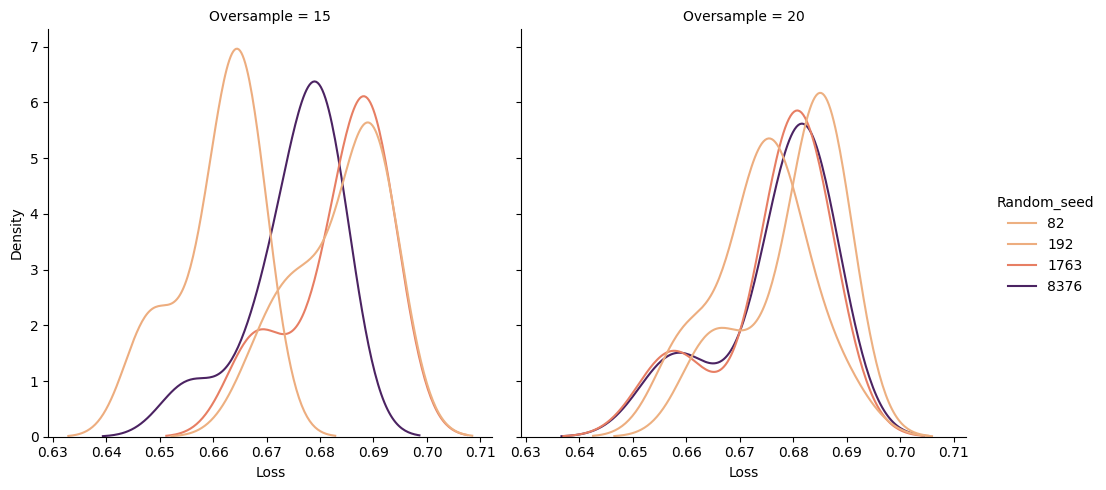

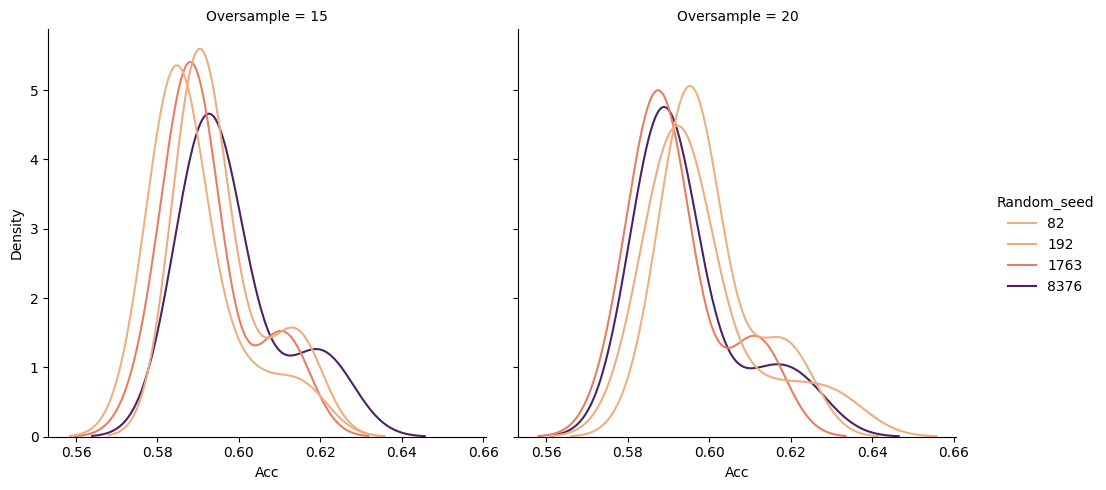

In [96]:
for met in ['Loss', 'Acc']:
    sns.displot(data=grp_summ_df, col='Oversample', x=met, hue='Random_seed', 
                kind='kde', palette='flare', hue_order=rand_seeds)
    plt.savefig(f'./results_Sens5/Diff_groupings_{met}.png', dpi=100)

In [97]:
corr_fn = pearsonr
corr_dict = {'Oversample':[], 'Rand_seed_pair':[], corr_fn.__name__:[], 'Metric':[]}
for sens_type, ovs in zip(sens_types, oversample):
    for j in range(len(rand_seeds)):
        exp_name = f'{sens_type}_{j}_{ovs}'
        exp_summ_path = (f'NN_Logs/'+
            f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
            f'{label}_Chr{exp_name}_2500bp_summary.csv')
        dfj = pd.read_csv(exp_summ_path)
        dfj = process_df(dfj)

        for k in range(j+1, len(rand_seeds)):
            exp_name = f'{sens_type}_{k}_{ovs}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            dfk = pd.read_csv(exp_summ_path)
            dfk = process_df(dfk)

            for metric in ['Acc', 'Loss']:
                x = dfj[metric].values
                y = dfk[metric].values
                r, p = corr_fn(x, y)
                corr_dict['Oversample'].append(ovs)
                corr_dict['Rand_seed_pair'].append(f'{j}_{k}')
                corr_dict[corr_fn.__name__].append(r)
                corr_dict['Metric'].append(metric)
corr_df = pd.DataFrame.from_dict(corr_dict)


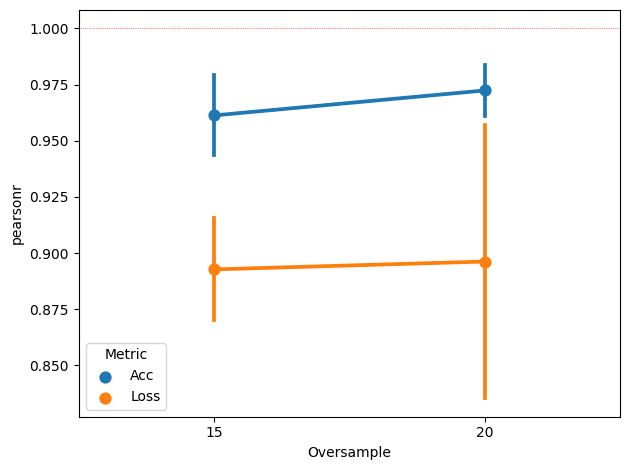

In [98]:
sns.pointplot(data=corr_df, x='Oversample', y=corr_fn.__name__, hue='Metric', 
              errorbar='sd')
plt.axhline(y=1, xmin=0, xmax=1, linestyle=':', c='r', linewidth='0.5')
plt.tight_layout()
plt.savefig(f'./results_Sens5/Diff_groupings_{corr_fn.__name__}.png', dpi=100)

### Sens4 vs Sens5

In [99]:
oversample = [15, 20, 15, 20]
sens_types = ['Sens5', 'Sens5', 'Sens4.1', 'Sens3']
rand_seeds = [82, 192, 8376, 1763]
grp_size = 20

In [101]:
for label in ['MATERNAL_MARIONI']:
    grp_summ_df = []
    for sens_type, ovs in zip(sens_types, oversample):
        for si, seed in enumerate(rand_seeds):
            exp_name = f'{sens_type}_{si}_{ovs}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            summ_df = pd.read_csv(exp_summ_path)
            summ_df = process_df(summ_df)
            summ_df['Group_size'] = grp_size
            summ_df['Oversample'] = ovs
            summ_df['Random_seed'] = seed
            summ_df['Sens'] = '1:5' if sens_type == 'Sens5' else '1:1'
            summ_df = summ_df[['Group_size', 'Oversample', 'Random_seed', 'Sens', 'Gene', 'Acc', 'Loss']]
            grp_summ_df.append(summ_df)
    grp_summ_df = pd.concat(grp_summ_df, ignore_index=True)

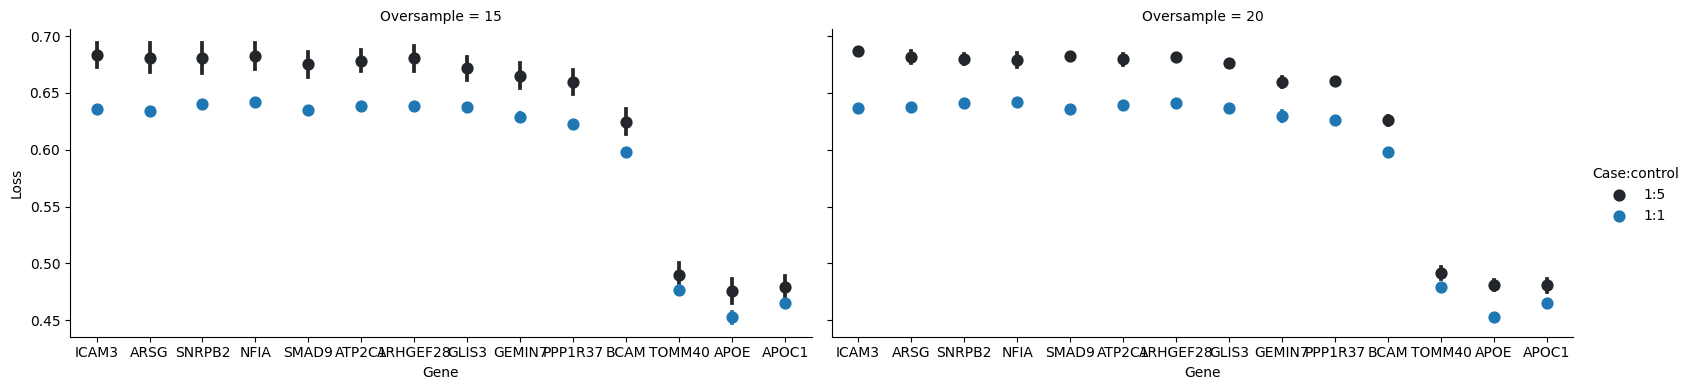

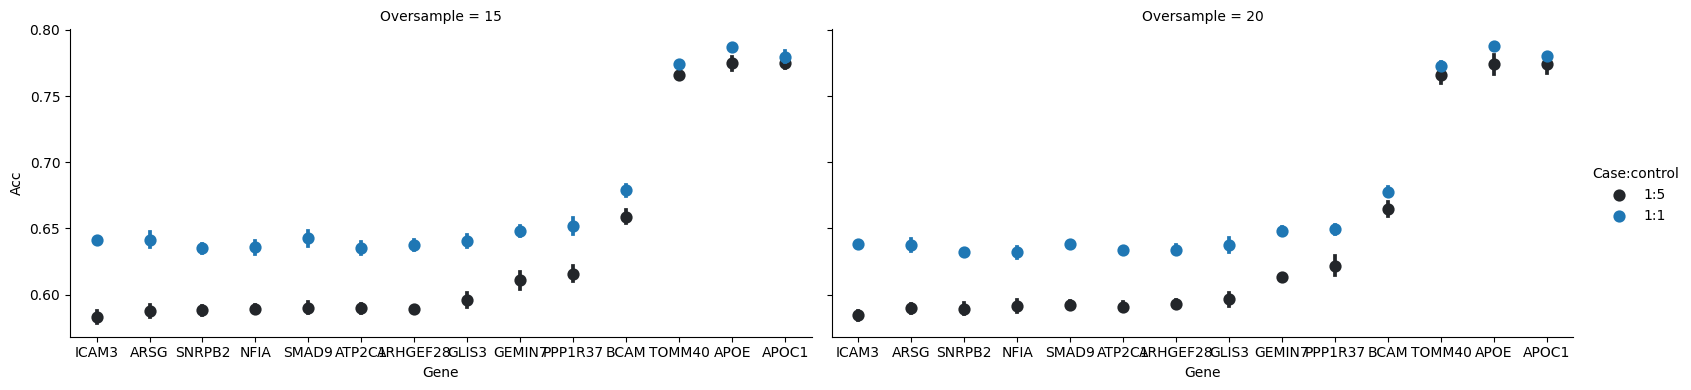

In [102]:
grp_summ_df.sort_values(['Acc', 'Gene', 'Sens'], inplace=True)
x_order = grp_summ_df.drop_duplicates('Gene')['Gene'].to_list()
for met in ['Loss', 'Acc']:
    fg = sns.FacetGrid(data=grp_summ_df, col='Oversample', 
                       col_order=np.unique(grp_summ_df['Oversample']), 
                       height=4, aspect=2, sharex=True, sharey=True)
    fg.map_dataframe(sns.pointplot, x='Gene', y=met, order=x_order, 
                     hue='Sens', errorbar='sd', join=False)
    fg.add_legend(title='Case:control')
    # sns.displot(data=grp_summ_df, col='Oversample', x=met, hue='Random_seed', 
    #             kind='kde', palette='flare', hue_order=rand_seeds)
    # plt.savefig(f'./results_Sens5/Diff_case_control_ratio_{met}.png', dpi=100)

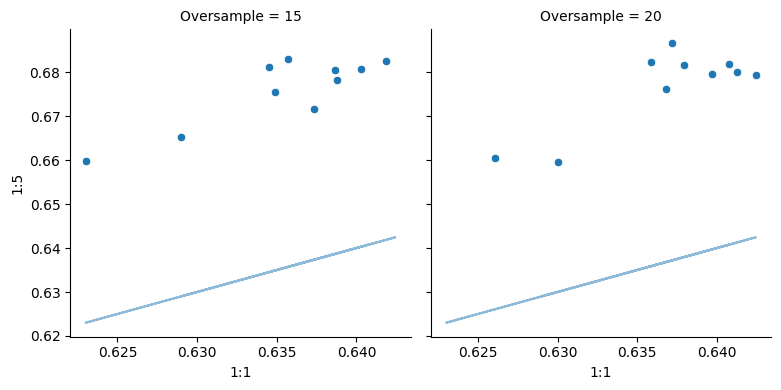

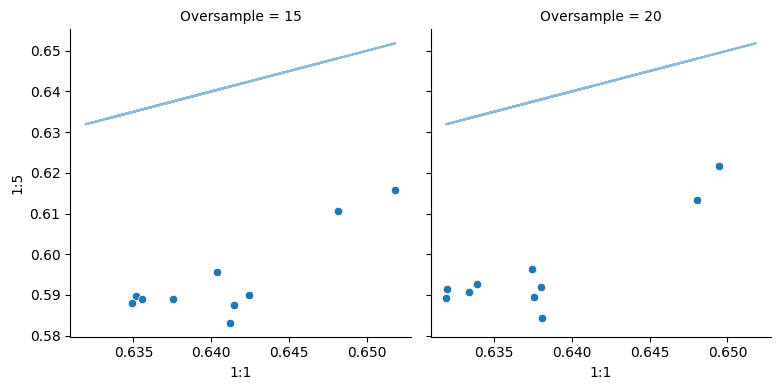

In [93]:
for met in ['Loss', 'Acc']:
    df = grp_summ_df.groupby(['Gene', 'Oversample', 'Sens']).mean(numeric_only=True).reset_index()
    df = pd.pivot(data=df, columns='Sens', values=met, index=['Gene', 'Oversample']).reset_index()
    
    fg = sns.FacetGrid(data=df, col='Oversample',
                       col_order=np.unique(grp_summ_df['Oversample']), 
                       height=4, aspect=1, sharex=True, sharey=True)
    fg.map_dataframe(sns.scatterplot, data=df, x='1:1', y='1:5')
    axes = fg.fig.axes
    x = df['1:1'].values
    y = x
    for ax in axes:
        ax.plot(y, x, alpha=0.5)
    # lim = (min(grp_summ_df[met]), max(grp_summ_df[met]))
    # fg.set(xlim=lim, ylim=lim)

## Sens7 and Sens8


### Correlation plots

In [3]:
def corr_plots(comb_df, fig_size1=(8, 4), fig_size2=(8, 8)):
    cols = comb_df.columns
    fig1, axes = plt.subplots(1, 2, figsize=fig_size1)
    axes = axes.flatten()
    for i, func in enumerate(['pearson', 'spearman']):
        ax = axes[i]
        corr = comb_df.corr(func)
        np.fill_diagonal(corr.values, np.nan)
        
        corr = np.tril(corr.values)
        corr = np.where(corr != 0, corr, np.ones_like(corr)*np.nan)
        sns.heatmap(corr, 
                    xticklabels=cols,
                    yticklabels=cols,
                    cmap='Reds',
                    vmin=0, vmax=1,
                    annot=True,
                    linewidths=0.5,
                    ax=ax)
        ax.set_xlabel('{Torch}{Python}')
        ax.set_ylabel('{Torch}{Python}')
        ax.set_title(f'{func} heatmap')
    fig1.tight_layout()

    try:
        df = comb_df.drop(index=['APOE_0'])
    except:
        df = comb_df
    fig2, axes = plt.subplots(nrows=len(cols), ncols=len(cols), figsize=fig_size2)
    for i in range(0,len(cols)):
        for j in range(i+1,len(cols)):
            if i == j: 
                axes[i,j].axis('off')
            else:
                x = df[cols[i]]
                y = df[cols[j]]
                
                axes[j,i].scatter(x, y, s=2, alpha=0.15)
                axes[j,i].set_title(cols[j] + " vs " + cols[i])
    fig2.tight_layout()
    
    return (fig1, fig2)

### Non-smooth metric curves

In [60]:
grp_sizes = [10]
# tseeds = [8162, 918, 61, 1502, 163, 712, 4250, 0]
# rseeds = [8162, 918, 61, 1502, 163, 712, 4250, 0]
# tseeds = [163, 712, 4250, 0]
# rseeds = [163, 712, 4250, 0]
tseeds = [163, 712, 0]
rseeds = [163, 712, 0]
metric = 'Loss'
greater_is_better = False
version = 'v8'

In [3]:
comb_df = pd.DataFrame(columns=['Gene'])
for gs in grp_sizes:
    for tseed, rseed in zip(tseeds, rseeds):
        exp_name = f'Sens8_{tseed}{rseed}_GS{gs}_{version}'
        exp_folder = f'./NN_Logs/FH_AD_Chr{exp_name}_GWANNet5_[32,16]_Dr_0.5_LR:0.005_BS:256_Optim:adam'
        summ_df = pd.read_csv(f'{exp_folder}/FH_AD_Chr{exp_name}_2500bp_summary.csv')
        # summ_df = process_df(summ_df)
        summ_df.set_index('Gene', inplace=True)
        if len(comb_df) == 0:
            comb_df['Gene'] = summ_df.index.values
        comb_df[f'GS{gs}_{tseed}{rseed}'] = summ_df.loc[comb_df['Gene']][metric].values
comb_df.set_index('Gene', inplace=True)
comb_df = comb_df.loc[~ (comb_df.index.str.contains('APOE') | 
                            comb_df.index.str.contains('APOC1') | 
                            comb_df.index.str.contains('TOMM40') | 
                            comb_df.index.str.contains('BCAM')) ]

NameError: name 'grp_sizes' is not defined

In [ ]:
cols = [c for c in comb_df.columns]
fig1, fig2 = corr_plots(comb_df[cols], fig_size1=(15, 7))
# fig1.savefig('GS20_corr.png', dpi=200)
display(fig1)
plt.close()
plt.close()

### Different combinations of averaging r runs

In [62]:
for gs in grp_sizes:
    cols = [c for c in comb_df.columns if c.startswith(f'GS{gs}_')]
    print(cols)
    for r in [1, 3]:
        for ci in range(0, len(rseeds), r):
            c = cols[ci:ci+r]
            comb_df[f'GS{gs}_Avg{r}_{ci}'] = np.mean(comb_df[c].values, axis=1)
        
        # plot_cols = [c for c in comb_df.columns if c.startswith(f'GS{gs}_Avg{r}')]
        # fig1, fig2 = corr_plots(comb_df[plot_cols])
        # fig1.savefig(f'GS{gs}_Avg{r}_corr.png', dpi=200)
        # plt.close()
        # plt.close()
# for r in [2, 4, 8]:
#     plot_cols = [c for c in comb_df.columns if f'Avg{r}' in c]
#     fig1, fig2 = corr_plots(comb_df[plot_cols], fig_size1=(15, 7))
#     fig1.savefig(f'Avg{r}_corr.png', dpi=200)
#     plt.close()
#     plt.close()

comb_df.head()

['GS10_163163', 'GS10_712712', 'GS10_00']


,GS10_163163,GS10_712712,GS10_00,GS10_Avg1_0,GS10_Avg1_1,GS10_Avg1_2,GS10_Avg3_0
Gene,,,,,,,
ACOT12_4,0.693560,0.693342,0.693171,0.693560,0.693342,0.693171,0.693358
ABR_10,0.693617,0.694595,0.694031,0.693617,0.694595,0.694031,0.694081
ABR_8,0.693091,0.693421,0.693699,0.693091,0.693421,0.693699,0.693403
ABR_9,0.693653,0.693366,0.693691,0.693653,0.693366,0.693691,0.693570
ABR_3,0.693690,0.693180,0.693473,0.693690,0.693180,0.693473,0.693448


In [ ]:
fig1, fig2 = corr_plots(comb_df=comb_df[[c for c in comb_df.columns if f'Avg{r}' in c]])
display(fig1, fig2)
plt.close()
plt.close()

### Dummy data avg metric across runs

In [63]:
dummy_df = pd.DataFrame(columns=['Gene'])
for gs in grp_sizes:
    for tseed, rseed in zip(tseeds, rseeds):
        exp_name = f'DummySens8_{tseed}{rseed}_GS{gs}_{version}'
        exp_folder = f'./NN_Logs/FH_AD_Chr{exp_name}_GWANNet5_[32,16]_Dr_0.5_LR:0.005_BS:256_Optim:adam'
        summ_df = pd.read_csv(f'{exp_folder}/FH_AD_Chr{exp_name}_2500bp_summary.csv')
        summ_df.set_index('Gene', inplace=True)
        if len(dummy_df) == 0:
            dummy_df['Gene'] = summ_df.index.values
        dummy_df[f'GS{gs}_{tseed}{rseed}'] = summ_df.loc[dummy_df['Gene']][metric].values
dummy_df.set_index('Gene', inplace=True)

In [64]:
from post_hoc import EstimatePValue
for gs in grp_sizes:
    cols = [c for c in comb_df.columns if c.startswith(f'GS{gs}_')]
    for r in [1, 3]:
        for ci in range(0, len(rseeds), r):
            
            c = cols[ci:ci+r]
            
            sign = 1 if greater_is_better else -1

            dummy_df[f'GS{gs}_Avg{r}_{ci}'] = sign*np.mean(dummy_df[list(c)].values, axis=1)
            
            ep = EstimatePValue(null_accs=dummy_df[f'GS{gs}_Avg{r}_{ci}'].values, 
                                greater_is_better=greater_is_better)
            
            comb_df[f'GS{gs}_Avg{r}_{ci}_logP'] = -np.log10(comb_df[f'GS{gs}_Avg{r}_{ci}'].apply(lambda x: ep.estimate(sign*x)).values)

/home/upamanyu/.pyenv/versions/3.8.15/envs/GWANN/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1722: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
/tmp/ipykernel_8670/735692800.py:16: RuntimeWarning: divide by zero encountered in log10
  comb_df[f'GS{gs}_Avg{r}_{ci}_logP'] = -np.log10(comb_df[f'GS{gs}_Avg{r}_{ci}'].apply(lambda x: ep.estimate(sign*x)).values)


GS10_Avg1_0_logP 9
GS10_Avg1_1_logP 33
GS10_Avg1_2_logP 62

GS10_Avg3_0_logP 56



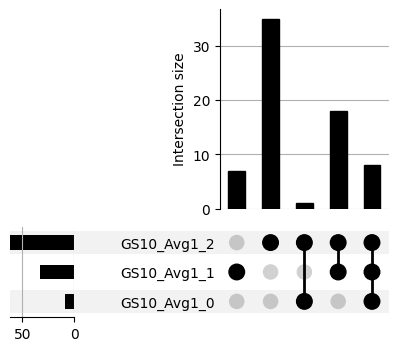

In [65]:
for r in [1, 3]:
    cols = [c for c in comb_df.columns if (f'Avg{r}' in c and c.endswith('logP'))]
    hit_dict = {}
    for key in cols:
        glist = comb_df.loc[comb_df[key] > -np.log10(7.05965407695023e-07)].index.values
        glist = set([g.split('_')[0] for g in glist])
        hit_dict[key.replace('_logP', '')] = glist
        print(key, len(glist))
    print()
    if len(cols) >= 2:
        upset_data = upsetplot.from_contents(hit_dict)
        up = upsetplot.plot(upset_data, include_empty_subsets=False, sort_categories_by='input')
        plt.savefig(f'Avg{r}_hit_overlap.png', dpi=200)

### Top K intersection

00: BIN1, PLCB1, ITPR3, PLCB4, ITPR2, APAF1, COX6A2, ATP2A2, CLU, COX8C
01: NDUFS1, ITPR3, BIN1, PLCB4, PPP3CA, GRIN2A, CLU, ITPR2, NDUFB10, ADAM17
10: PLCB4, COX4I2, GRIN2A, COX8C, COX6A1, GRIN2B, ITPR3, PLCB1, ITPR2, NDUFA4L2
11: BIN1, PLCB4, COX4I2, NDUFS1, COX7B2, ATP2A2, CLU, CYC1, LRP1, GRIN2B


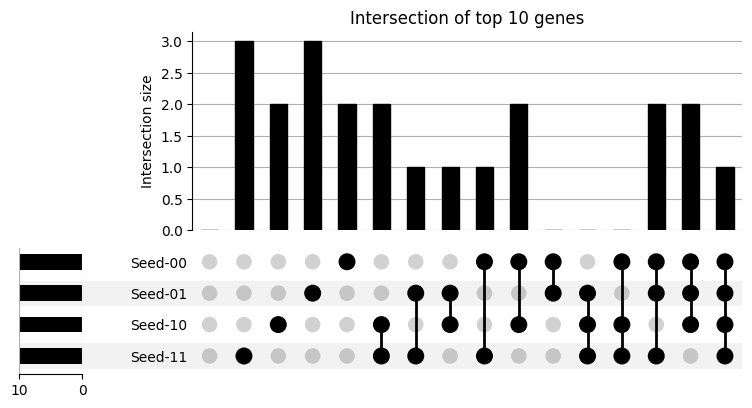

In [13]:
import upsetplot

for k in [10]:
    top_dict = {key:[] for key in comb_df.columns}
    for key in top_dict.keys():
        top_dict[key] = comb_df.sort_values(key, ascending=False).head(k).index.to_list()
        print(f'{key}: {", ".join(top_dict[key])}')
        top_dict[key] = set(top_dict[key])
    
    for key in list(top_dict.keys()):
        top_dict[f'Seed-{key}'] = top_dict.pop(key)

    upset_data = upsetplot.from_contents(top_dict)
    upsetplot.plot(upset_data, include_empty_subsets=True)
    plt.gca().set_title(f'Intersection of top {k} genes')
    # plt.savefig(f'./results_Sens7_00_GS10_v4/grp{grp_size}_top_{k}_upset.png')
    # plt.close()

### Correlation matrix

In [13]:
from IPython.display import display
fig1, fig2 = corr_plots(comb_df)
fig1.savefig(f'./results_Sens7_00_GS10_v4/grp{grp_size}_corr_heatmap_genes.png')
fig2.savefig(f'./results_Sens7_00_GS10_v4/grp{grp_size}_corr_scatter_genes.png')
plt.close()
plt.close()

### Smooth metric curves

In [8]:
import os
os.environ['TORCH_SEED'] = '0'
os.environ['GROUP_SEED'] = '1'
import sys
sys.path.append('..')
from GWANN.train_utils import metrics_from_conf_mat
import tqdm

def window_mean(X, w=5):
    X = np.concatenate((np.repeat(X[0], w//2), X, np.repeat(X[-1], w//2)))
    X_smooth = [] 
    for i in range(w//2, len(X)-w//2):
        window = X[i-w//2:i+w//2+1]
        window_average = np.mean(window)
        X_smooth.append(window_average)
        
    return X_smooth

grp_size = 10
comb_df = pd.DataFrame(columns=['Gene'])
for tseed, rseed in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    exp_name = f'Sens8_{tseed}{rseed}_GS{grp_size}_v4'
    exp_folder = f'/mnt/sdb/NN_Logs_archive/NN_Logs_Sens8/FH_AD_Chr{exp_name}_GWANNet5_[32,16]_Dr_0.5_LR:0.005_BS:256_Optim:adam'
    summ_df = pd.read_csv(f'{exp_folder}/FH_AD_Chr{exp_name}_2500bp_summary.csv')
    summ_df.set_index('Gene', drop=False, inplace=True)
    for g in tqdm.tqdm(summ_df.index.values):
        metrics = np.load(f'{exp_folder}/{g}/training_metrics.npz')
        train_loss = window_mean(metrics['agg_loss'][:, 0])
        test_loss = window_mean(metrics['agg_loss'][:, 1])
        train_acc = []
        test_acc = []
        for i, cm in enumerate(metrics['agg_conf_mat']):
            train_acc.append(metrics_from_conf_mat(cm[0])['acc'])
            test_acc.append(metrics_from_conf_mat(cm[1])['acc'])
        train_acc = window_mean(train_acc)
        test_acc = window_mean(test_acc)

        # met_df = pd.DataFrame(columns=['Epoch', 'Acc', 'Loss', 'Set'])
        # met_df['Epoch'] = np.tile(np.arange(len(train_acc)), 2)
        # met_df['Acc'] = np.concatenate((train_acc, test_acc))
        # met_df['Loss'] = np.concatenate((train_loss, test_loss))
        # met_df['Set'] = ['train']*len(train_acc) + ['test']*len(test_acc)

        # sns.lineplot(data=met_df, x='Epoch', y='Acc', style='Set', c='orange')
        # plt.savefig(f'{exp_folder}/{g}/smooth_acc.svg')
        # plt.close()

        # sns.lineplot(data=met_df, x='Epoch', y='Loss', style='Set', c='red')
        # plt.savefig(f'{exp_folder}/{g}/smooth_loss.svg')
        # plt.close()

        summ_df.loc[g, 'Loss'] = np.min(test_loss)
        summ_df.loc[g, 'Acc'] = test_acc[np.argmin(test_loss)]
        # summ_df.loc[g, 'Loss'] = test_loss[np.argmax(test_acc)]
        # summ_df.loc[g, 'Acc'] = np.max(test_acc)
    

    
    summ_df.reset_index(inplace=True, drop=True)
    summ_df = process_df(summ_df)
    summ_df.set_index('Gene', inplace=True)
    if len(comb_df) == 0:
        comb_df['Gene'] = summ_df.index.values
    comb_df[f'{tseed}{rseed}'] = summ_df.loc[comb_df['Gene']]['Acc'].values
comb_df.set_index('Gene', inplace=True)

  0%|          | 0/321 [00:00<?, ?it/s]


KeyError: 'agg_loss is not a file in the archive'

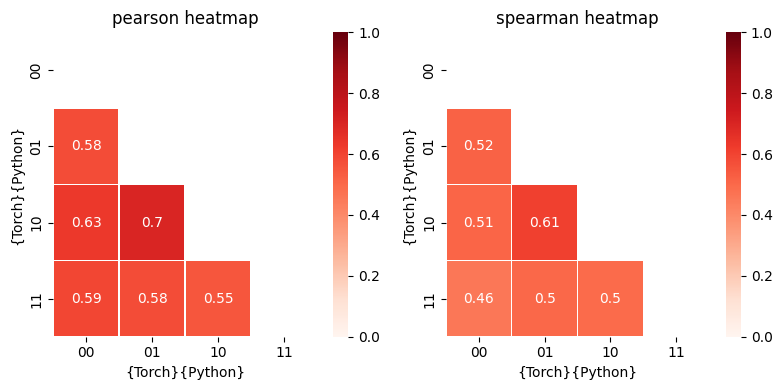

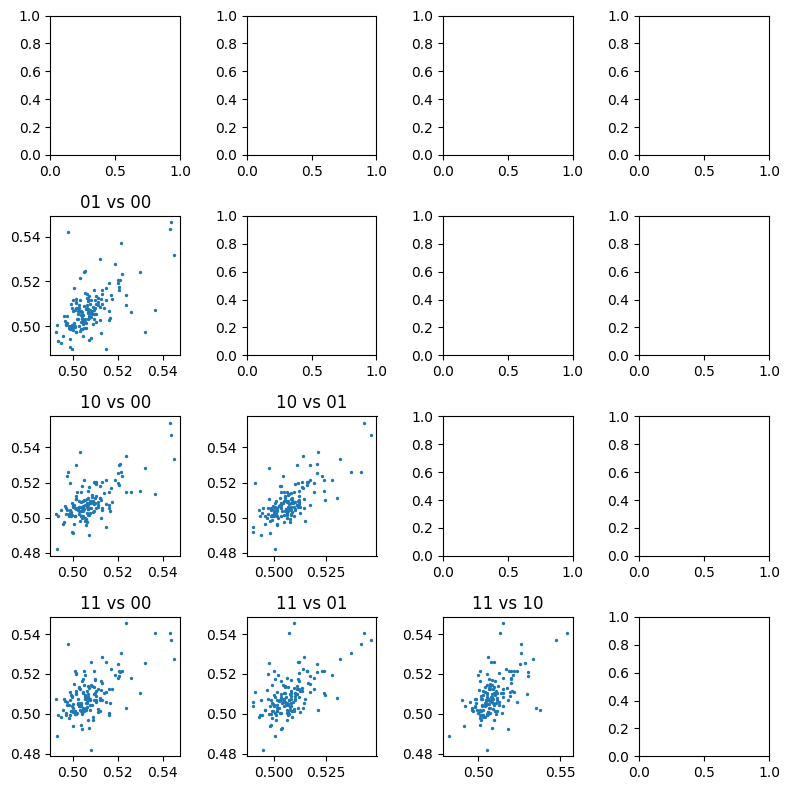

In [35]:
display(*corr_plots(comb_df))

### Correlation between group sizes

In [15]:
comb_df = pd.DataFrame(columns=['Gene'])
for grp_size in [10, 20]:
    for tseed, rseed in zip([0, 0, 1, 1], [0, 1, 0, 1]):
        exp_name = f'Sens7_{tseed}{rseed}_GS{grp_size}_v4'
        exp_folder = f'NN_Logs/FH_AD_Chr{exp_name}_GWANNet5_[32,16]_Dr_0.5_LR:0.005_BS:256_Optim:adam'
        summ_df = pd.read_csv(f'{exp_folder}/FH_AD_Chr{exp_name}_2500bp_summary.csv')
        summ_df = process_df(summ_df)
        summ_df.set_index('Gene', inplace=True)
        if len(comb_df) == 0:
            comb_df['Gene'] = summ_df.index.values
        comb_df[f'GS{grp_size}_{tseed}{rseed}'] = summ_df.loc[comb_df['Gene']]['Acc'].values
comb_df.set_index('Gene', inplace=True)

In [20]:
fig1, fig2 = corr_plots(comb_df, fig_size1=(16, 8), fig_size2=(16, 16))
fig1.savefig(f'./results_Sens7_00_GS10_v4/inter_grp_corr_heatmap_genes.png')
fig2.savefig(f'./results_Sens7_00_GS10_v4/inter_grp_corr_scatter_genes.png')
plt.close()
plt.close()

## Sens8 Stepped run

### Run1

In [84]:
grp_sizes = [10]
tseeds = [0, 712, 163]
rseeds = [0, 712, 163]
metric = 'Loss'
greater_is_better = False
version = 'v4'

comb_df = None
for gs in grp_sizes:
    for tseed, rseed in zip(tseeds, rseeds):
        exp_name = f'Sens8_{tseed}{rseed}_GS{gs}_{version}'
        exp_folder = f'./results_{exp_name}'
        summ_df = pd.read_csv(f'{exp_folder}/FH_AD_{metric}_{exp_name}_summary.csv')
        summ_df[f'GS{gs}_{tseed}{rseed}_P'] = summ_df['P'].values
        summ_df = summ_df[['Gene', f'GS{gs}_{tseed}{rseed}_P']]
        if comb_df is None:
            comb_df = summ_df.loc[(summ_df[f'GS{gs}_{tseed}{rseed}_P'] < 0.05) | 
                                  (summ_df['Gene'].isin(['BIN1_0', 'BIN1_1', 'BIN1_2', 'BIN1_3', 'BIN1_4', 'BIN1_5']))]

        else:
            comb_df = pd.merge(comb_df, summ_df, left_on='Gene', right_on='Gene', 
                               how='outer')
comb_df.set_index('Gene', inplace=True)

/tmp/ipykernel_18467/2610388625.py:3: RuntimeWarning: divide by zero encountered in log10
  tdf['agg_P'] = tdf.apply(lambda x: 10**np.mean(np.log10(x.values[:-1])), axis=1).values
/tmp/ipykernel_18467/2610388625.py:3: RuntimeWarning: divide by zero encountered in log10
  tdf['agg_P'] = tdf.apply(lambda x: 10**np.mean(np.log10(x.values[:-1])), axis=1).values


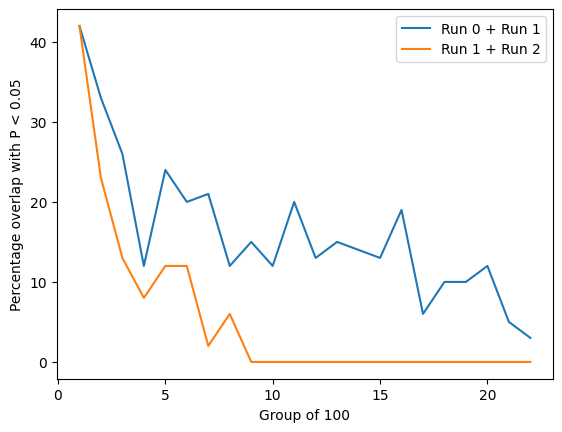

In [14]:
for i in range(comb_df.shape[1]-1):
    tdf = comb_df.iloc[:, :i+2].copy()
    tdf['agg_P'] = tdf.apply(lambda x: 10**np.mean(np.log10(x.values[:-1])), axis=1).values
    tdf = tdf[['agg_P', tdf.columns[-2]]]
    tdf = tdf.sort_values('agg_P')
    tdf = tdf < 0.05
    overlap = np.all(tdf.values, axis=1)
    overlap = np.array_split(overlap, np.arange(100, len(overlap), 100))
    overlap = np.array([np.count_nonzero(o) for o in overlap])
    sns.lineplot(x=np.arange(len(overlap))+1, y=overlap, label=f'Run {i} + Run {i+1}')
ax = plt.gca()
ax.set_xlabel('Group of 100')
ax.set_ylabel('Percentage overlap with P < 0.05')
plt.show()

In [85]:
comb_df['agg_P'] = comb_df.apply(lambda x: 10**np.mean(np.log10(x.values)), axis=1).values
# hit_genes1 = comb_df[comb_df['agg_P'] < 1e-6].index.to_list()
hit_genes1 = comb_df[comb_df['agg_P'] < (0.05/71000)].index.to_list()
# hit_genes1 = set(hit_genes1)
hit_genes1 = set([g.split('_')[0] for g in hit_genes1])
print(len(hit_genes1))

32


/tmp/ipykernel_18467/2773823011.py:1: RuntimeWarning: divide by zero encountered in log10
  comb_df['agg_P'] = comb_df.apply(lambda x: 10**np.mean(np.log10(x.values)), axis=1).values


### Run2

In [86]:
grp_sizes = [10]
tseeds = [4250, 8162, 918]
rseeds = [4250, 8162, 918]
metric = 'Loss'
greater_is_better = False
version = 'v4'

comb_df = None
for gs in grp_sizes:
    for tseed, rseed in zip(tseeds, rseeds):
        exp_name = f'Sens8_{tseed}{rseed}_GS{gs}_{version}'
        exp_folder = f'./results_{exp_name}'
        summ_df = pd.read_csv(f'{exp_folder}/FH_AD_{metric}_{exp_name}_summary.csv')
        summ_df[f'GS{gs}_{tseed}{rseed}_P'] = summ_df['P'].values
        summ_df = summ_df[['Gene', f'GS{gs}_{tseed}{rseed}_P']]
        if comb_df is None:
            comb_df = summ_df.loc[(summ_df[f'GS{gs}_{tseed}{rseed}_P'] < 0.05) | 
                                  (summ_df['Gene'].isin(['BIN1_0', 'BIN1_1', 'BIN1_2', 'BIN1_3', 'BIN1_4', 'BIN1_5']))]
        else:
            comb_df = pd.merge(comb_df, summ_df, left_on='Gene', right_on='Gene', 
                               how='outer')
comb_df.set_index('Gene', inplace=True)

/tmp/ipykernel_18467/2610388625.py:3: RuntimeWarning: divide by zero encountered in log10
  tdf['agg_P'] = tdf.apply(lambda x: 10**np.mean(np.log10(x.values[:-1])), axis=1).values
/tmp/ipykernel_18467/2610388625.py:3: RuntimeWarning: divide by zero encountered in log10
  tdf['agg_P'] = tdf.apply(lambda x: 10**np.mean(np.log10(x.values[:-1])), axis=1).values


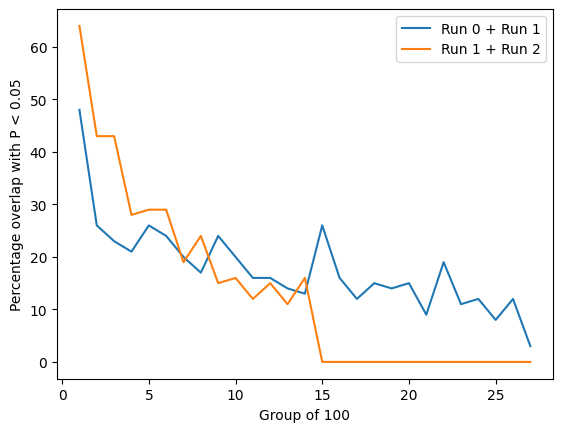

In [17]:
for i in range(comb_df.shape[1]-1):
    tdf = comb_df.iloc[:, :i+2].copy()
    tdf['agg_P'] = tdf.apply(lambda x: 10**np.mean(np.log10(x.values[:-1])), axis=1).values
    tdf = tdf[['agg_P', tdf.columns[-2]]]
    tdf = tdf.sort_values('agg_P')
    tdf = tdf < 0.05
    overlap = np.all(tdf.values, axis=1)
    overlap = np.array_split(overlap, np.arange(100, len(overlap), 100))
    overlap = np.array([np.count_nonzero(o) for o in overlap])
    sns.lineplot(x=np.arange(len(overlap))+1, y=overlap, label=f'Run {i} + Run {i+1}')
ax = plt.gca()
ax.set_xlabel('Group of 100')
ax.set_ylabel('Percentage overlap with P < 0.05')
plt.show()

In [87]:
comb_df['agg_P'] = comb_df.apply(lambda x: 10**np.mean(np.log10(x.values)), axis=1).values
# hit_genes2 = comb_df[comb_df['agg_P'] < 1e-6].index.to_list()
hit_genes2 = comb_df[comb_df['agg_P'] < (0.05/71000)].index.to_list()
# hit_genes2 = set(hit_genes2)
hit_genes2 = set([g.split('_')[0] for g in hit_genes2])
print(len(hit_genes2))

46


/tmp/ipykernel_18467/3267351003.py:1: RuntimeWarning: divide by zero encountered in log10
  comb_df['agg_P'] = comb_df.apply(lambda x: 10**np.mean(np.log10(x.values)), axis=1).values


### Run1 intersection Run2

0.3448275862068966

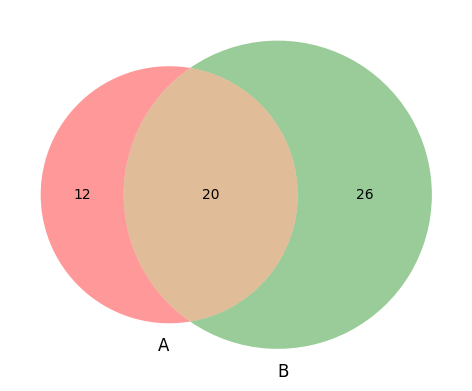

In [88]:
from matplotlib_venn import venn2
venn2([hit_genes1, hit_genes2])
i = hit_genes1.intersection(hit_genes2)
u = hit_genes1.union(hit_genes2)
len(i)/len(u)

In [89]:
hit_overlap = hit_genes1.intersection(hit_genes2)
with open('./params/reviewer_rerun_Sens8hit_overlap_2runs_.txt', 'w') as f:
    f.write('\n'.join(hit_overlap))

## Sens8 average over multiple runs

In [104]:
grp_sizes = [10]
tseeds = [0, 37, 89, 172, 281, 363, 937, 4250]
# tseeds = [0, 363, 937, 4250]
# tseeds = [37, 89, 172, 281]
rseeds = tseeds
metric = 'Loss'
greater_is_better = False
version = 'v4'
sign = 1 if greater_is_better else -1

comb_df = None
for gs in grp_sizes:
    for tseed, rseed in zip(tseeds, rseeds):
        exp_name = f'Sens8_{tseed}{rseed}_GS{gs}_{version}'
        exp_folder = f'./results_Sens8_v4/results_{exp_name}'
        summ_df = pd.read_csv(f'{exp_folder}/FH_AD_{metric}_{exp_name}_summary.csv')
        summ_df.drop_duplicates(['Gene'], inplace=True)
        
        colname = f'GS{gs}_{tseed}{rseed}_P'
        # summ_df[colname] = summ_df[metric].values
        summ_df[colname] = summ_df['P'].values
        vals = summ_df[colname].values
        summ_df.loc[vals == 0, colname] = np.min(vals[vals != 0]) * 1e-10
        
        if comb_df is None:
            comb_df = summ_df[['Gene', 'Chrom', colname]]
        else:
            summ_df = summ_df[['Gene', colname]]
            comb_df = pd.merge(comb_df, summ_df, left_on='Gene', right_on='Gene', 
                               how='outer') 

comb_df.set_index(['Gene', 'Chrom'], inplace=True)
comb_df.head()

,,GS10_00_P,GS10_3737_P,GS10_8989_P,GS10_172172_P,GS10_281281_P,GS10_363363_P,GS10_937937_P,GS10_42504250_P
Gene,Chrom,,,,,,,,
AADACL3_0,1,0.774769,0.527537,0.820988,1.000000,0.564382,0.382036,0.716315,0.936193
ABCA4_6,1,0.459116,0.621437,0.467773,0.447060,0.265752,0.928864,0.301337,0.946804
AADACL4_1,1,0.426328,0.290151,0.301647,0.491979,0.275979,0.998400,0.380737,0.429102
ABCA4_5,1,0.468396,0.328406,0.628691,0.408880,0.581387,0.776105,0.280968,0.581701
ABCA4_3,1,0.419138,0.267127,0.390998,0.316174,0.151780,0.581282,0.465197,0.854811


### Harmonic Mean P combination of P-values

In [105]:
comb_df.reset_index().to_csv('./results_Sens8_v4/results_Sens8_v4_avg/agg_P_matrix.csv', index=False)

In [78]:
!Rscript combine_p.R

Loading required package: FMStable
[1] "Error with  APOC1_0 . Setting agg_p to 0"
[1] "Error with  APOE_0 . Setting agg_p to 0"
[1] "Error with  BCAM_0 . Setting agg_p to 0"
[1] "Error with  TOMM40_0 . Setting agg_p to 0"
[1] "Error with  TOMM40_1 . Setting agg_p to 0"


In [ ]:
combined_p = pd.read_csv('./results_Sens8_v4/results_Sens8_v4_avg/agg_P_matrix_hmp.csv')
combined_p['Gene']  = combined_p['Gene'].apply(lambda x: x.split('_')[0])
combined_p.sort_values(['Gene', 'adj_p_bonf'], inplace=True)
combined_p.sort_values(['adj_p_bonf'], inplace=True)
combined_p = combined_p[['Gene', 'Chrom', 'adj_p_bonf', 'adj_p_hmp', 'adj_p_simple']]
combined_p.drop_duplicates(['Gene'], inplace=True)
bonf = combined_p.loc[combined_p['adj_p_bonf'] < 0.05]
hmp = combined_p.loc[combined_p['adj_p_hmp'] < 0.05]
simple = combined_p.loc[combined_p['adj_p_simple'] < 0.05]

In [115]:
combined_p = pd.read_csv('./results_Sens8_v4/results_Sens8_v4_avg/agg_P_matrix_hmp.csv')
combined_p['Gene']  = combined_p['Gene'].apply(lambda x: x.split('_')[0])
combined_p.sort_values(['Gene', 'adj_p_simple'], inplace=True)
combined_p.sort_values(['adj_p_simple'], inplace=True)
combined_p = combined_p[['Gene', 'Chrom', 'adj_p_simple']]
combined_p.drop_duplicates(['Gene'], inplace=True)
simple = combined_p.loc[combined_p['adj_p_simple'] < 0.05]

In [116]:
simple

,Gene,Chrom,adj_p_simple
56168,TOMM40,19,2.615318e-240
54282,BCAM,19,2.615318e-240
54226,APOE,19,2.615318e-240
54228,APOC1,19,2.615318e-240
54304,BCL3,19,8.547522e-200
54222,APOC1P1,19,3.044400e-148
55784,RELB,19,7.633399e-142
54522,CLPTM1,19,1.019008e-86
56404,ZNF296,19,1.811143e-55
55650,PPP1R37,19,2.645725e-35


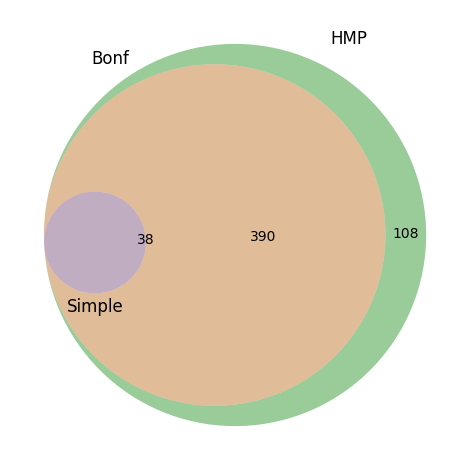

In [49]:
# Upset plot of the four different gene lists
from matplotlib_venn import venn3

hit_dict = {'Bonf':set(bonf['Gene']), 'HMP':set(hmp['Gene']), 'Simple':set(simple['Gene'])}
venn3(hit_dict.values(), set_labels=hit_dict.keys())
plt.tight_layout()
plt.savefig('p_agg_venn.png', dpi=100)

In [103]:
pairs = [(1, 2), (3, 4), (5, 6), (7, 8)]
# p_iou = {'bonf':[], 'hmp':[], 'simple':[]}
# for adj in ['bonf', 'hmp', 'simple']:
p_iou = {'simple':[]}
for adj in ['simple']:
    for pair in pairs:
        hits = {p:[] for p in pair}
        for p in pair:
            agg_df = pd.read_csv(f'./results_Sens8_v4/results_Sens8_v4_avg/agg_P_matrix_hmp_{p}.csv')
            agg_df['Gene'] = agg_df['Gene'].apply(lambda x: x.split('_')[0])
            
            agg_df.sort_values(['Gene', f'adj_p_{adj}'], inplace=True)
            agg_df.drop_duplicates(['Gene'], inplace=True)
            hits[p] = set(agg_df.loc[agg_df[f'adj_p_{adj}'] < 0.05]['Gene'].to_list())

        iou = len(hits[pair[0]].intersection(hits[pair[1]])) / len(hits[pair[0]].union(hits[pair[1]]))
        p_iou[adj].append(iou)
        print(f'{adj} {pair}: {iou}')
        print(hits[pair[0]])
        print(hits[pair[1]])
        print()

simple (1, 2): 0.75
{'BCAM', 'RPS6KC1', 'ZNF296', 'RELB', 'APOC1', 'CEACAM16', 'CLPTM1', 'BCL3', 'LRRC7', 'EXOC3L2', 'APOC1P1', 'PPP1R37', 'CBLC', 'TOMM40', 'APOE'}
{'BCAM', 'RPS6KC1', 'ZWILCH', 'APOC1', 'CEACAM16', 'CLPTM1', 'BCL3', 'EXOC3L2', 'APOC1P1', 'PPP1R37', 'CBLC', 'TOMM40', 'APOE'}

simple (3, 4): 0.5882352941176471
{'BCAM', 'ZNF296', 'RELB', 'APOC1', 'CLPTM1', 'BCL3', 'LRRC7', 'APOC1P1', 'PPP1R37', 'CBLC', 'TOMM40', 'APOE'}
{'LINGO2', 'BCAM', 'RPS6KC1', 'RELB', 'APOC1', 'CEACAM16', 'CLPTM1', 'BCL3', 'EXOC3L2', 'AKR1C6P', 'APOC1P1', 'PPP1R37', 'CBLC', 'TOMM40', 'APOE'}

simple (5, 6): 0.47058823529411764
{'BCAM', 'RPS6KC1', 'RELB', 'APOC1', 'BIN1', 'CEACAM16', 'CLPTM1', 'BCL3', 'EXOC3L2', 'APOC1P1', 'PPP1R37', 'CBLC', 'TOMM40', 'APOE'}
{'BCAM', 'ZNF296', 'APOC1', 'CLPTM1', 'BCL3', 'LRRC7', 'EPHA5', 'APOC1P1', 'PPP1R37', 'TOMM40', 'APOE'}

simple (7, 8): 0.6923076923076923
{'BCAM', 'RPS6KC1', 'APOC1', 'CLPTM1', 'BCL3', 'APOC1P1', 'PPP1R37', 'CBLC', 'TOMM40', 'APOE'}
{'BCAM', '

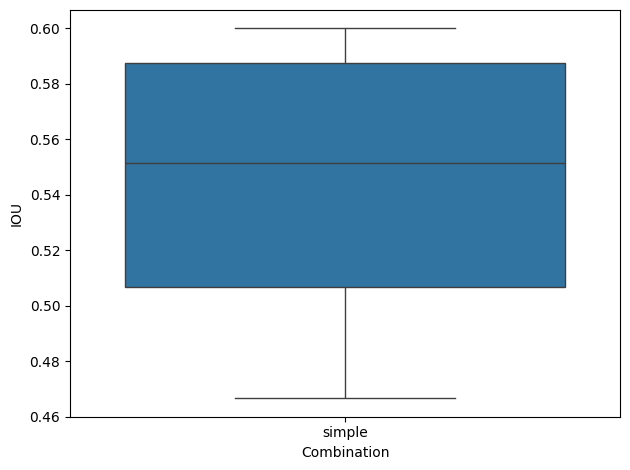

In [100]:
plot_df = pd.DataFrame.from_dict(p_iou)
plot_df = pd.melt(plot_df, var_name='Combination', value_name='IOU')
sns.boxplot(data=plot_df, x='Combination', y='IOU')
plt.tight_layout()
plt.savefig('p_agg_iou_both_extreme.png', dpi=100)

### Multi-run average

In [52]:
dummy_df = pd.DataFrame(columns=['Gene'])
for gs in grp_sizes:
    for tseed, rseed in zip(tseeds, rseeds):
        exp_name = f'DummySens8_{tseed}{rseed}_GS{gs}_{version}'
        exp_folder = f'./NN_Logs/FH_AD_Chr{exp_name}_GWANNet5_[32,16]_Dr_0.5_LR:0.005_BS:256_Optim:adam'
        summ_df = pd.read_csv(f'{exp_folder}/FH_AD_Chr{exp_name}_2500bp_summary.csv')
        summ_df.set_index('Gene', inplace=True)
        if len(dummy_df) == 0:
            dummy_df['Gene'] = summ_df.index.values
        dummy_df[f'GS{gs}_{tseed}{rseed}_{metric}'] = summ_df.loc[dummy_df['Gene']][metric].values
dummy_df.set_index('Gene', inplace=True)
dummy_df.head()

,GS10_00_Acc,GS10_3737_Acc,GS10_8989_Acc,GS10_172172_Acc,GS10_281281_Acc,GS10_363363_Acc,GS10_937937_Acc,GS10_42504250_Acc
Gene,,,,,,,,
Dummy0_12,0.503504,0.479513,0.516449,0.501009,0.504751,0.500475,0.504513,0.500534
Dummy0_23,0.511461,0.490914,0.504394,0.512411,0.494656,0.487352,0.497981,0.486104
Dummy0_13,0.513123,0.490855,0.498694,0.497862,0.505819,0.502672,0.502256,0.498515
Dummy0_3,0.493230,0.485867,0.502969,0.497447,0.497862,0.498872,0.495428,0.485689
Dummy0_17,0.509917,0.500831,0.502613,0.503563,0.498990,0.501722,0.506770,0.506235


In [7]:
def ncr(a, r, k):
    cs = list(combinations(a, r))
    np.random.shuffle(cs)
    for c in cs:
        if k != 0:
            yield list(c)
        k -=1 

cols = comb_df.columns.to_list()
comb_df.rename(columns={c:f'1_{ci}_{metric}' for ci, c in enumerate(cols)}, inplace=True)
cols = comb_df.columns.to_list()
comb_df.head()

avgs = {
    1: [c for c in ncr(cols, 1, len(cols))],
    2: [c for c in ncr(cols, 2, 10)],
    3: [c for c in ncr(cols, 3, 7)],
    4: [c for c in ncr(cols, 4, 5)],
    5: [c for c in ncr(cols, 5, 3)],
    6: [c for c in ncr(cols, 6, 1)]
}

# for k, vs in avgs.items():
#     for vi, v in enumerate(vs):
#         if len(v) > 1:
#             comb_df[f'{k}_{vi}_P'] = 10**comb_df[v].apply(lambda x: np.mean(np.log10(x)), axis=1).values
        
#         _, corr_p, _, alpha_bonf = multipletests(comb_df[f'{k}_{vi}_P'].values, method='bonferroni')
#         comb_df[f'{k}_{vi}_P_adj'] = corr_p

# comb_df.head()

,,1_0_Loss,1_1_Loss,1_2_Loss,1_3_Loss,1_4_Loss,1_5_Loss,1_6_Loss,1_7_Loss
Gene,Chrom,,,,,,,,
AADACL3_0,1.0,0.693742,0.693398,0.693958,0.698953,0.693605,0.693295,0.693801,0.694345
ABCA4_6,1.0,0.693306,0.693509,0.693339,0.693311,0.693188,0.694421,0.693182,0.694413
AADACL4_1,1.0,0.693269,0.693111,0.693127,0.693360,0.693202,0.695585,0.693289,0.693240
ABCA4_5,1.0,0.693317,0.693161,0.693572,0.693270,0.693632,0.693914,0.693154,0.693451
ABCA4_3,1.0,0.693261,0.693079,0.693240,0.693173,0.693015,0.693563,0.693403,0.694005


In [24]:
gene_comb_df = comb_df.copy()
gene_comb_df.reset_index(inplace=True)

In [6]:
summ_df = gene_comb_df.copy()
summ_df.rename(columns={'6_0_P_adj':'P_bonf', '6_0_P':'P'}, 
               inplace=True)
summ_df = summ_df[['Gene', 'Chrom', 'P', 'P_bonf']]
summ_df.head()
summ_df.to_csv('results_Sens8_v4_avg/FH_AD_Loss_Sens8_v4_avg_summary.csv', 
               index=False)

summ_df['Gene'] = summ_df['Gene'].apply(lambda x: x.split('_')[0]).values
summ_df.sort_values(['Gene', f'P_bonf'], ascending=True, inplace=True)
summ_df.drop_duplicates('Gene', inplace=True)
summ_df.loc[summ_df['P_bonf'] < 0.05]['Gene'].to_csv('results_Sens8_v4_avg/hits.txt', index=False)

In [25]:
avg_hits = {}
for k, vs in avgs.items():
    avg_hits[k] = []
    for vi, v in enumerate(vs):
        tdf = gene_comb_df[['Gene', 'Chrom', f'{k}_{vi}_P_adj']].copy()
        tdf['Gene'] = tdf['Gene'].apply(lambda x: x.split('_')[0]).values
        tdf.sort_values(['Gene', f'{k}_{vi}_P_adj'], ascending=True, inplace=True)
        tdf.drop_duplicates('Gene', inplace=True)
        avg_hits[k].append(set(tdf.loc[tdf[f'{k}_{vi}_P_adj'] < 0.05]['Gene'].values))

### IOU analysis for different averages

In [26]:
gwas_catalog = pd.read_csv('/home/upamanyu/GWANN/Code_AD/enrichment_scripts/gwas_catalog_AD_groups.csv')
gwas_catalog_AD = set(gwas_catalog.loc[gwas_catalog['DISEASE/TRAIT'] == 'Alzheimer']['Gene'].values)
len(gwas_catalog_AD)

1061

In [27]:
def intersection(a, b):
    return len(a.intersection(b))

def IOU(a, b):
    i = a.intersection(b)
    u = a.union(b)
    return len(i)/len(u)

def DOU(a, b):
    i = a.difference(b)
    u = a.union(b)
    return len(i)/len(u)

def int_prop(a, b):
    i = a.intersection(b)
    return len(i)/len(a)

plot_df = {'Num_runs_avgd':[], 'IOU':[], 'DOU':[], 'Int_prop':[], 'hit_size':[]}
for k, vs in avg_hits.items():
    for vi, v in enumerate(vs):
        iou = IOU(v, gwas_catalog_AD)
        dou = DOU(v, gwas_catalog_AD)
        ip = int_prop(v, gwas_catalog_AD)
        i = intersection(v, gwas_catalog_AD)
        print(f'{k}_{vi}: {len(v):<4} {i:<2} {iou:.3f} {dou:.3f} {ip:.3f}')
        
        plot_df['Num_runs_avgd'].append(k)
        plot_df['IOU'].append(iou)
        plot_df['DOU'].append(dou)
        plot_df['Int_prop'].append(ip)
        plot_df['hit_size'].append(len(v))
    
    print()

1_0: 89   30 0.027 0.053 0.337
1_1: 107  23 0.020 0.073 0.215
1_2: 69   22 0.020 0.042 0.319
1_3: 127  23 0.020 0.089 0.181
1_4: 252  50 0.040 0.160 0.198
1_5: 119  19 0.016 0.086 0.160

2_0: 119  29 0.025 0.078 0.244
2_1: 116  31 0.027 0.074 0.267
2_2: 54   22 0.020 0.029 0.407
2_3: 109  31 0.027 0.068 0.284
2_4: 61   22 0.020 0.035 0.361
2_5: 122  34 0.030 0.077 0.279
2_6: 47   18 0.017 0.027 0.383
2_7: 68   24 0.022 0.040 0.353
2_8: 58   20 0.018 0.035 0.345
2_9: 82   27 0.024 0.049 0.329
2_10: 72   24 0.022 0.043 0.333
2_11: 75   27 0.024 0.043 0.360
2_12: 111  29 0.025 0.072 0.261
2_13: 64   26 0.024 0.035 0.406

3_0: 41   20 0.018 0.019 0.488
3_1: 82   27 0.024 0.049 0.329
3_2: 58   22 0.020 0.033 0.379
3_3: 73   25 0.023 0.043 0.342
3_4: 59   22 0.020 0.034 0.373
3_5: 55   24 0.022 0.028 0.436
3_6: 72   26 0.023 0.042 0.361
3_7: 89   30 0.027 0.053 0.337
3_8: 50   19 0.017 0.028 0.380
3_9: 88   28 0.025 0.054 0.318
3_10: 91   26 0.023 0.058 0.286
3_11: 77   25 0.022 0.047 0.325


In [28]:
plot_df = pd.DataFrame.from_dict(plot_df)
plot_df.head()

,Num_runs_avgd,IOU,DOU,Int_prop,hit_size
0,1,0.026786,0.052679,0.337079,89
1,1,0.020087,0.073362,0.214953,107
2,1,0.019856,0.042419,0.318841,69
3,1,0.019742,0.089270,0.181102,127
4,1,0.039588,0.159937,0.198413,252


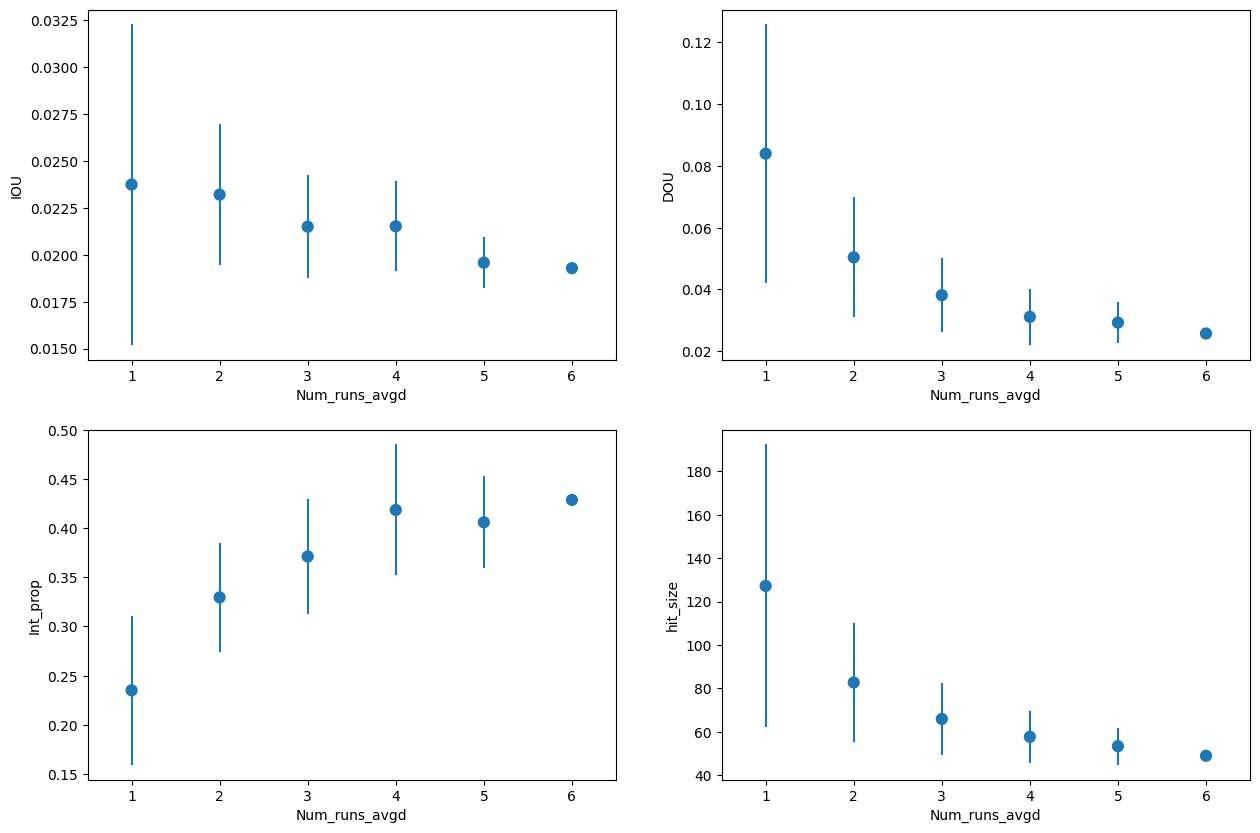

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharey=False)
ax = ax.flatten()
for ax, c in zip(ax, ['IOU', 'DOU', 'Int_prop', 'hit_size']):
    sns.pointplot(data=plot_df, x='Num_runs_avgd', y=c, 
                  errorbar='sd', join=False, ax=ax, errwidth=1.5)
                  

### STRING PPI analysis for different averages

In [30]:
from enrichment_scripts.STRING_enrichment import STRING_PPI_enrichment

string_enrichment = {'Num_runs_avgd':[], 'PPI_enrichment_P':[], 'hit_size':[]}
for k, vs in avg_hits.items():
    for vi, v in enumerate(vs):
        string_enrichment['Num_runs_avgd'].append(k)
        PPI_dict = STRING_PPI_enrichment(list(v))
        # print(f'{k}_{vi}: {PPI_dict}')
        string_enrichment['PPI_enrichment_P'].append(float(PPI_dict['p_value']))
        string_enrichment['hit_size'].append(len(v))

In [31]:
string_enrichment = pd.DataFrame.from_dict(string_enrichment)
string_enrichment['-log10(PPI enrichment P)'] = -np.log10(string_enrichment['PPI_enrichment_P'].values)
vals = string_enrichment['-log10(PPI enrichment P)'].values
string_enrichment.loc[np.isinf(vals), '-log10(PPI enrichment P)'] = np.max(vals[~np.isinf(vals)]) + 5 

/tmp/ipykernel_18335/1497378421.py:2: RuntimeWarning: divide by zero encountered in log10
  string_enrichment['-log10(PPI enrichment P)'] = -np.log10(string_enrichment['PPI_enrichment_P'].values)


<AxesSubplot:xlabel='Num_runs_avgd', ylabel='-log10(PPI enrichment P)'>

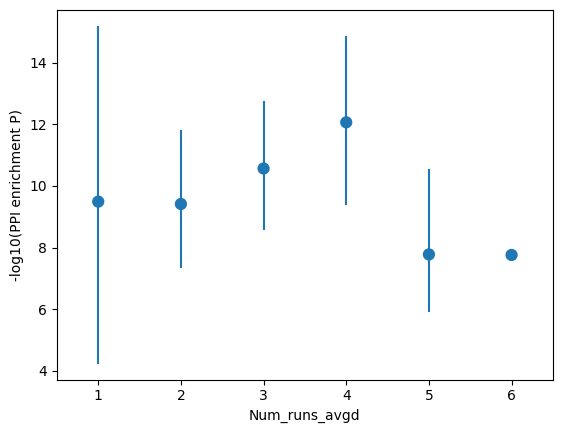

In [32]:
sns.pointplot(data=string_enrichment, x='Num_runs_avgd', y='-log10(PPI enrichment P)', 
              join=False, errorbar='ci', errwidth=1.5)

### Comparison between averaged runs

In [35]:
comb_df.loc[comb_df.isna().any(axis=1)]

,,GS10_00_Loss,GS10_3737_Loss,GS10_8989_Loss,GS10_172172_Loss,GS10_281281_Loss,GS10_363363_Loss,GS10_937937_Loss,GS10_42504250_Loss
Gene,Chrom,,,,,,,,


In [36]:
corr_dict = {'spearman_r':[], 'num_avgd':[], 'col_pairs':[], 'avg1_hits':[], 
            'avg2_hits':[], 'A':[], 'B':[], 'IOU':[], 'top50_IOU':[], 
            'hit_intersection':[]}

In [37]:
from post_hoc import EstimatePValue
import yaml

def no_intersection_comb_pairs(a, r, num_pairs):
    
    cs = list(combinations(a, r))
    if r > len(a)//2:
        return None
    
    s1 = cs.pop()
    cnt = 0
    while len(cs) >= 1:
        s2 = cs.pop()
        if len(set(s1).intersection(set(s2))) == 0:
            yield [list(s1), list(s2)]
            if len(cs) >= 1:
                s1 = cs.pop()
            cnt += 1
        else:
            cs = [s2] + cs
        
        if cnt == num_pairs:
            break

def get_hits(df):
    df = df.reset_index()
    
    df['Gene'] = df['Gene'].apply(lambda x: x.split('_')[0]).values
    # df[0] = 10**df[0]
    _, corr_p, _, alpha_bonf = multipletests(df['P'].values, method='bonferroni')
    df['corr_P'] = corr_p

    df.sort_values(['Gene', 'corr_P'], ascending=True, inplace=True)
    df.drop_duplicates('Gene', inplace=True)
    return df.loc[df['corr_P'] < 0.05].sort_values('corr_P')['Gene'].values

corr_dict_file = f'./results_Sens8_v4_avg/Sens8_avg_{metric}_corr_dict.yaml'
if not os.path.exists(corr_dict_file):
    for r in [1, 2, 3, 4]:
        num_pairs = 10
        col_pairs = list(no_intersection_comb_pairs(comb_df.columns.to_list(), r, num_pairs))
        for col_pair in col_pairs:
            corr_dict['col_pairs'].append(f'{":".join(col_pair[0])} vs {":".join(col_pair[1])}')
            print(corr_dict['col_pairs'][-1])

            avg = {0:None, 1:None}
            for pair in [0, 1]:
                avg[pair] = pd.DataFrame(index=comb_df.index, columns=[metric, 'P'])
                avg[pair][metric] = sign*comb_df[col_pair[pair]].apply(lambda x: np.mean(x), axis=1).values
                print(f'\tPair {pair}: Metric averaged')
                
                avg_dummy_metric = sign*np.mean(dummy_df[list(col_pair[pair])].values, axis=1)
                print(f'\tPair {pair}: Dummy metric averaged')
                
                ep = EstimatePValue(null_accs=avg_dummy_metric)
                avg[pair]['P'] = avg[pair][metric].apply(lambda x: ep.estimate(x)).values
                print(f'\tPair {pair}: P-value calculated')
            
            rho, p = spearmanr(avg[0][metric].values, avg[1][metric].values)
            corr_dict['spearman_r'].append(rho)
            corr_dict['num_avgd'].append(r)
            
            avg1_hits = get_hits(avg[0])
            avg2_hits = get_hits(avg[1])      
            i = set(avg1_hits).intersection(set(avg2_hits))
            u = set(avg1_hits).union(set(avg2_hits))
            
            top50_i = set(avg1_hits[:50]).intersection(set(avg2_hits[:50]))
            top50_u = set(avg1_hits[:50]).union(set(avg2_hits[:50]))
            
            corr_dict['IOU'].append(len(i)/len(u))
            corr_dict['top50_IOU'].append(len(top50_i)/len(top50_u))
            corr_dict['avg1_hits'].append(",".join(sorted(list(avg1_hits))))
            corr_dict['A'].append(len(avg1_hits))
            corr_dict['avg2_hits'].append(",".join(sorted(list(avg2_hits))))
            corr_dict['B'].append(len(avg2_hits))
            corr_dict['hit_intersection'].append(",".join(sorted(list(i))))
            
            print('\t',{k:np.round(corr_dict[k][-1], 3) for k in corr_dict.keys() if k not in ['col_pairs', 'hit_intersection', 'avg1_hits', 'avg2_hits']})
            print()

    yaml_dict = {k:list(v) for k, v in corr_dict.items()}
    yaml_dict['spearman_r'] = [float(v) for v in yaml_dict['spearman_r']]
    with open(corr_dict_file, 'w') as f:
        yaml.dump(yaml_dict, f)
else:
    with open(corr_dict_file, 'r') as f:
        corr_dict = yaml.load(f, Loader=yaml.FullLoader)

GS10_42504250_Loss vs GS10_937937_Loss
	Pair 0: Metric averaged
	Pair 0: Dummy metric averaged
	Pair 0: P-value calculated
	Pair 1: Metric averaged
	Pair 1: Dummy metric averaged
	Pair 1: P-value calculated
	 {'spearman_r': 0.22, 'num_avgd': 1, 'A': 121, 'B': 66, 'IOU': 0.133, 'top50_IOU': 0.124}

GS10_363363_Loss vs GS10_281281_Loss
	Pair 0: Metric averaged
	Pair 0: Dummy metric averaged
	Pair 0: P-value calculated
	Pair 1: Metric averaged
	Pair 1: Dummy metric averaged
	Pair 1: P-value calculated
	 {'spearman_r': 0.094, 'num_avgd': 1, 'A': 111, 'B': 100, 'IOU': 0.105, 'top50_IOU': 0.124}

GS10_172172_Loss vs GS10_8989_Loss
	Pair 0: Metric averaged
	Pair 0: Dummy metric averaged
	Pair 0: P-value calculated
	Pair 1: Metric averaged
	Pair 1: Dummy metric averaged
	Pair 1: P-value calculated
	 {'spearman_r': 0.192, 'num_avgd': 1, 'A': 244, 'B': 104, 'IOU': 0.149, 'top50_IOU': 0.235}

GS10_3737_Loss vs GS10_00_Loss
	Pair 0: Metric averaged
	Pair 0: Dummy metric averaged
	Pair 0: P-value c

In [38]:
# Code to concatenate 2 the corr_dicts for Acc and Loss and add an additional
# key called 'metric' to identify the metric
with open('./results_Sens8_v4_avg/Sens8_avg_Acc_corr_dict.yaml', 'r') as f:
    corr_dict = yaml.load(f, Loader=yaml.FullLoader)
    corr_dict['metric'] = ['Acc']*len(corr_dict['spearman_r'])

with open('./results_Sens8_v4_avg/Sens8_avg_Loss_corr_dict.yaml', 'r') as f:
    corr_dict2 = yaml.load(f, Loader=yaml.FullLoader)
    corr_dict2['metric'] = ['Loss']*len(corr_dict2['spearman_r'])

for k in corr_dict.keys():
    corr_dict[k] += corr_dict2[k]


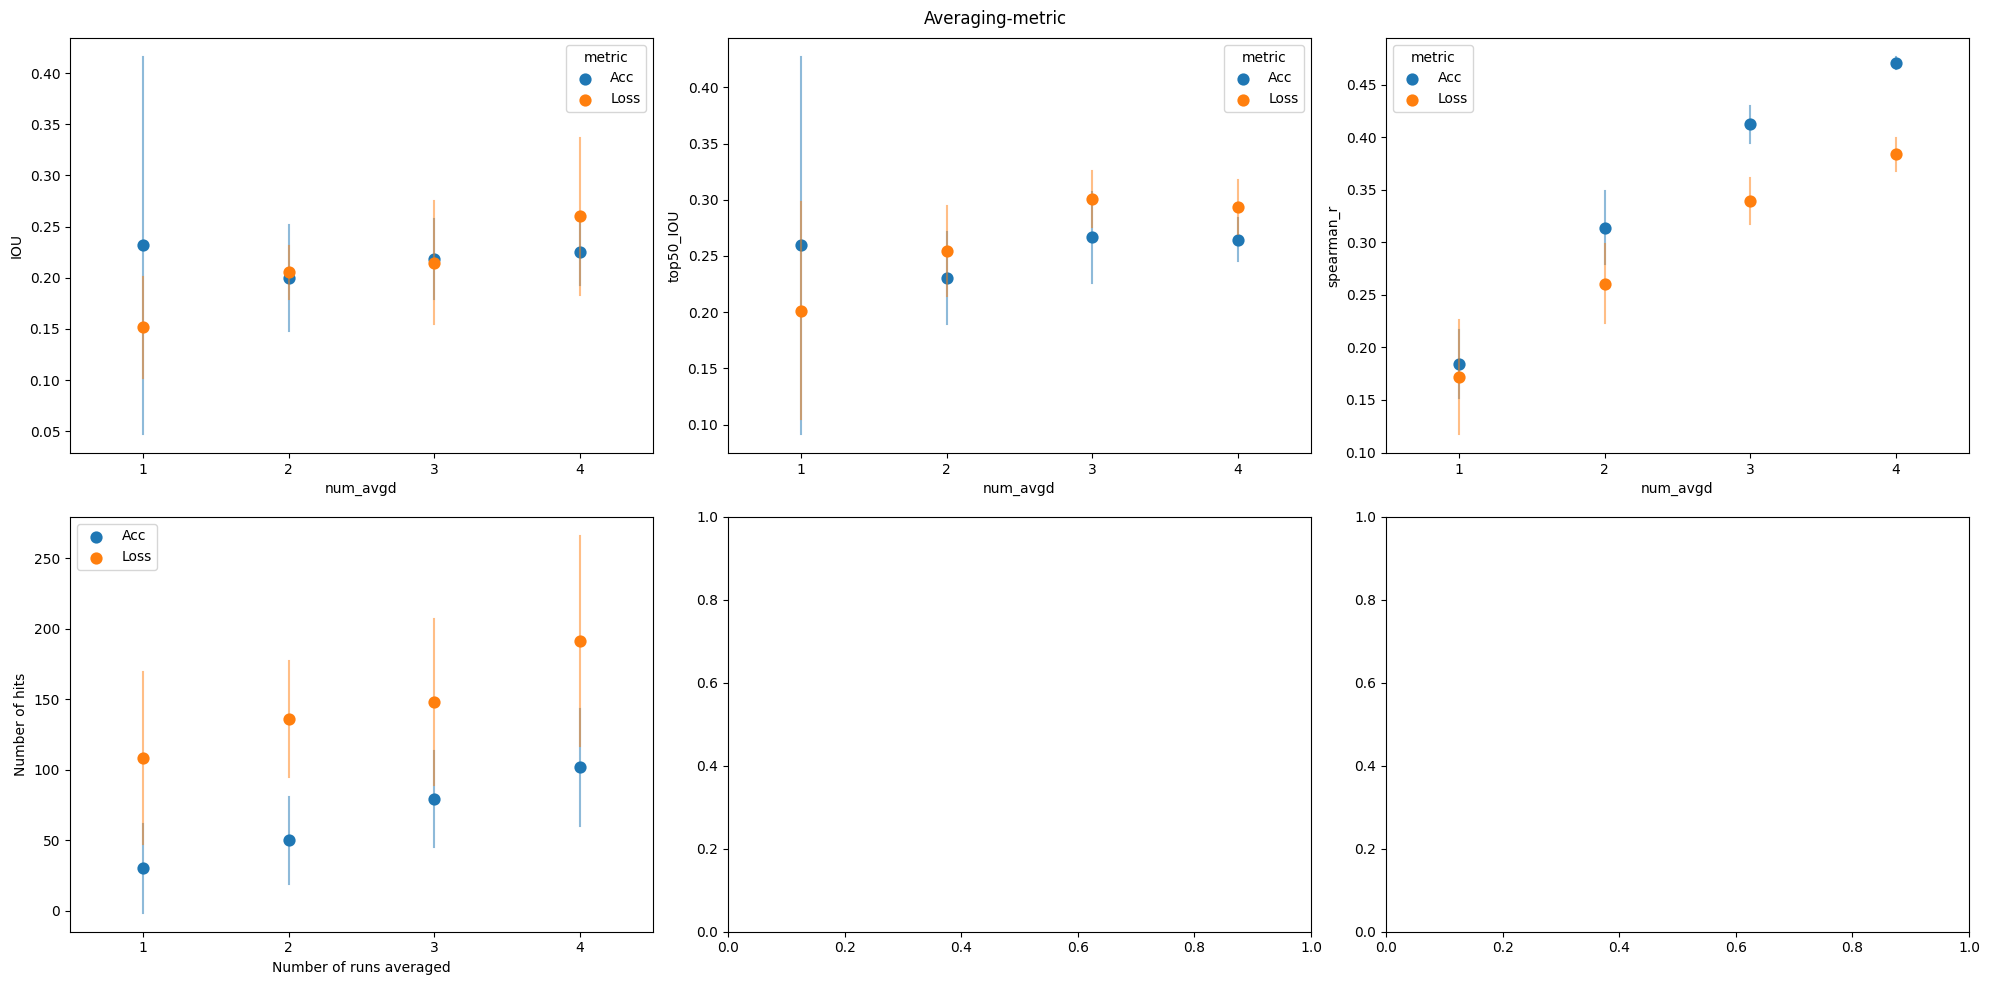

In [42]:
plot_df = pd.DataFrame(corr_dict)
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=False)
axes = axes.flatten()
for ax, c in zip(axes, ['IOU', 'top50_IOU', 'spearman_r']):
    sns.pointplot(data=plot_df, x='num_avgd', y=c, hue='metric',
                  errorbar='sd', join=False, ax=ax, errwidth=1.5)
    plt.setp(ax.lines, alpha=.5)

num_avgd = np.tile(plot_df['num_avgd'].values, 2)
hit_size = np.concatenate((plot_df['A'].values, plot_df['B'].values))
hue = np.concatenate((plot_df['metric'].values, plot_df['metric'].values))
sns.pointplot(x=num_avgd, y=hit_size, hue=hue, join=False, errwidth=1.5, 
                errorbar='sd', ax=axes[3])
plt.setp(axes[3].lines, alpha=.5)
axes[3].set_xlabel('Number of runs averaged')
axes[3].set_ylabel('Number of hits')
plot_title = f'Averaging-metric'
plt.gcf().suptitle(plot_title)
plt.tight_layout()
plt.savefig(f'./results_Sens8_v4_avg/{plot_title}.png')
plt.show()

### Hit genes after averaging over 8 runs

In [57]:
avg = pd.DataFrame(index=comb_df.index, columns=[metric, 'P'])
avg[metric] = sign*comb_df.apply(lambda x: np.mean(x), axis=1).values
avg_dummy_metric = sign*dummy_df.apply(lambda x: np.mean(x), axis=1).values
ep = EstimatePValue(null_accs=avg_dummy_metric)
avg['P'] = avg[metric].apply(lambda x: ep.estimate(x)).values

# Bonferroni correction
avg = avg.reset_index()
avg['Gene'] = avg['Gene'].apply(lambda x: x.split('_')[0]).values
_, corr_p, _, alpha_bonf = multipletests(avg['P'].values, method='bonferroni')
avg['corr_P'] = corr_p
avg.sort_values(['Gene', 'corr_P'], ascending=True, inplace=True)
avg.drop_duplicates('Gene', inplace=True)
avg.loc[avg['corr_P'] < 0.05].sort_values('corr_P')


,Gene,Chrom,Acc,P,corr_P
72986,TOMM40,19,0.671133,0.000000e+00,0.000000e+00
69112,APOC1,19,0.685689,0.000000e+00,0.000000e+00
69108,APOE,19,0.689178,0.000000e+00,0.000000e+00
69220,BCAM,19,0.603407,7.972409e-195,6.968763e-190
69264,BCL3,19,0.551626,2.175166e-52,1.901334e-47
...,...,...,...,...,...
79300,TMPRSS12,12,0.515306,4.895240e-07,4.278979e-02
67096,RAP1GAP2,17,0.515276,5.112675e-07,4.469040e-02
38145,ESRP1,8,0.515269,5.168476e-07,4.517817e-02
28262,TTK,6,0.515224,5.515874e-07,4.821481e-02


In [58]:
avg.loc[avg['corr_P'] < 0.05].to_csv(f'results_Sens8_v4_avg/gene_hits_{metric}.csv', index=False)

### Comparison between averaged runs: avg -log(p)

In [59]:
grp_sizes = [10]
tseeds = [0, 37, 89, 172, 281, 363, 937, 4250]
rseeds = tseeds
metric = 'Loss'
version = 'v4'

comb_df = None
for gs in grp_sizes:
    for tseed, rseed in zip(tseeds, rseeds):
        exp_name = f'Sens8_{tseed}{rseed}_GS{gs}_{version}'
        exp_folder = f'./results_{exp_name}'
        summ_df = pd.read_csv(f'{exp_folder}/FH_AD_{metric}_{exp_name}_summary.csv')
        summ_df[f'GS{gs}_{tseed}{rseed}_P'] = np.log10(summ_df['P'].values)
        
        if comb_df is None:
            comb_df = summ_df[['Gene', 'Chrom', f'GS{gs}_{tseed}{rseed}_P']]
        else:
            summ_df = summ_df[['Gene', f'GS{gs}_{tseed}{rseed}_P']]
            comb_df = pd.merge(comb_df, summ_df, left_on='Gene', right_on='Gene', 
                               how='outer') 

comb_df.set_index(['Gene', 'Chrom'], inplace=True)
comb_df.head()

/tmp/ipykernel_20106/554716106.py:13: RuntimeWarning: divide by zero encountered in log10
  summ_df[f'GS{gs}_{tseed}{rseed}_P'] = np.log10(summ_df['P'].values)
/tmp/ipykernel_20106/554716106.py:13: RuntimeWarning: divide by zero encountered in log10
  summ_df[f'GS{gs}_{tseed}{rseed}_P'] = np.log10(summ_df['P'].values)
/tmp/ipykernel_20106/554716106.py:13: RuntimeWarning: divide by zero encountered in log10
  summ_df[f'GS{gs}_{tseed}{rseed}_P'] = np.log10(summ_df['P'].values)
/tmp/ipykernel_20106/554716106.py:13: RuntimeWarning: divide by zero encountered in log10
  summ_df[f'GS{gs}_{tseed}{rseed}_P'] = np.log10(summ_df['P'].values)
/tmp/ipykernel_20106/554716106.py:13: RuntimeWarning: divide by zero encountered in log10
  summ_df[f'GS{gs}_{tseed}{rseed}_P'] = np.log10(summ_df['P'].values)
/tmp/ipykernel_20106/554716106.py:13: RuntimeWarning: divide by zero encountered in log10
  summ_df[f'GS{gs}_{tseed}{rseed}_P'] = np.log10(summ_df['P'].values)
/tmp/ipykernel_20106/554716106.py:13: Ru

,,GS10_00_P,GS10_3737_P,GS10_8989_P,GS10_172172_P,GS10_281281_P,GS10_363363_P,GS10_937937_P,GS10_42504250_P
Gene,Chrom,,,,,,,,
AADACL3_0,1,-0.110828,-0.277747,-0.085663,0.000000,-0.248427,-0.417896,-0.144896,-0.028635
ABCA4_6,1,-0.338078,-0.206603,-0.329965,-0.349634,-0.575524,-0.032048,-0.520948,-0.023740
AADACL4_1,1,-0.370256,-0.537376,-0.520500,-0.308053,-0.559124,-0.000696,-0.419375,-0.367440
ABCA4_5,1,-0.329387,-0.483588,-0.201563,-0.388405,-0.235535,-0.110080,-0.551343,-0.235300
ABCA4_3,1,-0.377643,-0.573282,-0.407825,-0.500074,-0.818786,-0.235613,-0.332363,-0.068130


In [8]:
comb_df.loc[comb_df.isna().any(axis=1)]

,,GS10_00_P,GS10_3737_P,GS10_8989_P,GS10_172172_P,GS10_281281_P,GS10_363363_P,GS10_937937_P,GS10_42504250_P
Gene,Chrom,,,,,,,,


In [9]:
corr_dict = {'spearman_r':[], 'num_avgd':[], 'col_pairs':[], 'avg1_hits':[], 
            'avg2_hits':[], 'A':[], 'B':[], 'IOU':[], 'top50_IOU':[], 
            'hit_intersection':[]}

In [18]:
from post_hoc import EstimatePValue
import yaml

def no_intersection_comb_pairs(a, r, num_pairs):
    
    cs = list(combinations(a, r))
    if r > len(a)//2:
        return None
    
    s1 = cs.pop()
    cnt = 0
    while len(cs) >= 1:
        s2 = cs.pop()
        if len(set(s1).intersection(set(s2))) == 0:
            yield [list(s1), list(s2)]
            if len(cs) >= 1:
                s1 = cs.pop()
            cnt += 1
        else:
            cs = [s2] + cs
        
        if cnt == num_pairs:
            break

def get_hits(df):
    df = df.reset_index()
    
    df['Gene'] = df['Gene'].apply(lambda x: x.split('_')[0]).values
    df['P'] = 10**df['P']
    _, corr_p, _, alpha_bonf = multipletests(df['P'].values, method='bonferroni')
    df['corr_P'] = corr_p

    df.sort_values(['Gene', 'corr_P'], ascending=True, inplace=True)
    df.drop_duplicates('Gene', inplace=True)
    return df.loc[df['corr_P'] < 0.05].sort_values('corr_P')['Gene'].values

# Load corr_dict from disk if saved, else compute it
corr_dict_file = f'./results_Sens8_v4_avg/Sens8_p_avg_{metric}_corr_dict.yaml'
if not os.path.exists(corr_dict_file):
    for r in [1, 2, 3, 4]:
        num_pairs = 10
        col_pairs = list(no_intersection_comb_pairs(comb_df.columns.to_list(), r, num_pairs))
        for col_pair in col_pairs:
            corr_dict['col_pairs'].append(f'{":".join(col_pair[0])} vs {":".join(col_pair[1])}')
            print(corr_dict['col_pairs'][-1])

            avg = {0:None, 1:None}
            for pair in [0, 1]:
                avg[pair] = comb_df[col_pair[pair]].apply(lambda x: np.mean(x), axis=1)
                avg[pair].name = 'P'
                print(f'\tPair {pair}: Metric averaged')
                
            rho, p = spearmanr(avg[0].values, avg[1].values)
            corr_dict['spearman_r'].append(rho)
            corr_dict['num_avgd'].append(r)
            
            avg1_hits = get_hits(avg[0])
            avg2_hits = get_hits(avg[1])      
            i = set(avg1_hits).intersection(set(avg2_hits))
            u = set(avg1_hits).union(set(avg2_hits))
            
            top50_i = set(avg1_hits[:50]).intersection(set(avg2_hits[:50]))
            top50_u = set(avg1_hits[:50]).union(set(avg2_hits[:50]))
            
            corr_dict['IOU'].append(len(i)/len(u))
            corr_dict['top50_IOU'].append(len(top50_i)/len(top50_u))
            corr_dict['avg1_hits'].append(",".join(sorted(list(avg1_hits))))
            corr_dict['A'].append(len(avg1_hits))
            corr_dict['avg2_hits'].append(",".join(sorted(list(avg2_hits))))
            corr_dict['B'].append(len(avg2_hits))
            corr_dict['hit_intersection'].append(",".join(sorted(list(i))))
            
            print('\t',{k:np.round(corr_dict[k][-1], 3) for k in corr_dict.keys() if k not in ['col_pairs', 'hit_intersection', 'avg1_hits', 'avg2_hits']})
            print()

    yaml_dict = {k:list(v) for k, v in corr_dict.items()}
    yaml_dict['spearman_r'] = [float(v) for v in yaml_dict['spearman_r']]
    with open(corr_dict_file, 'w') as f:
        yaml.dump(yaml_dict, f)
else:
    with open(f'./results_Sens8_v4_avg/Sens8_p_avg_{metric}_corr_dict.yaml', 'r') as f:
        corr_dict = yaml.load(f, Loader=yaml.FullLoader)


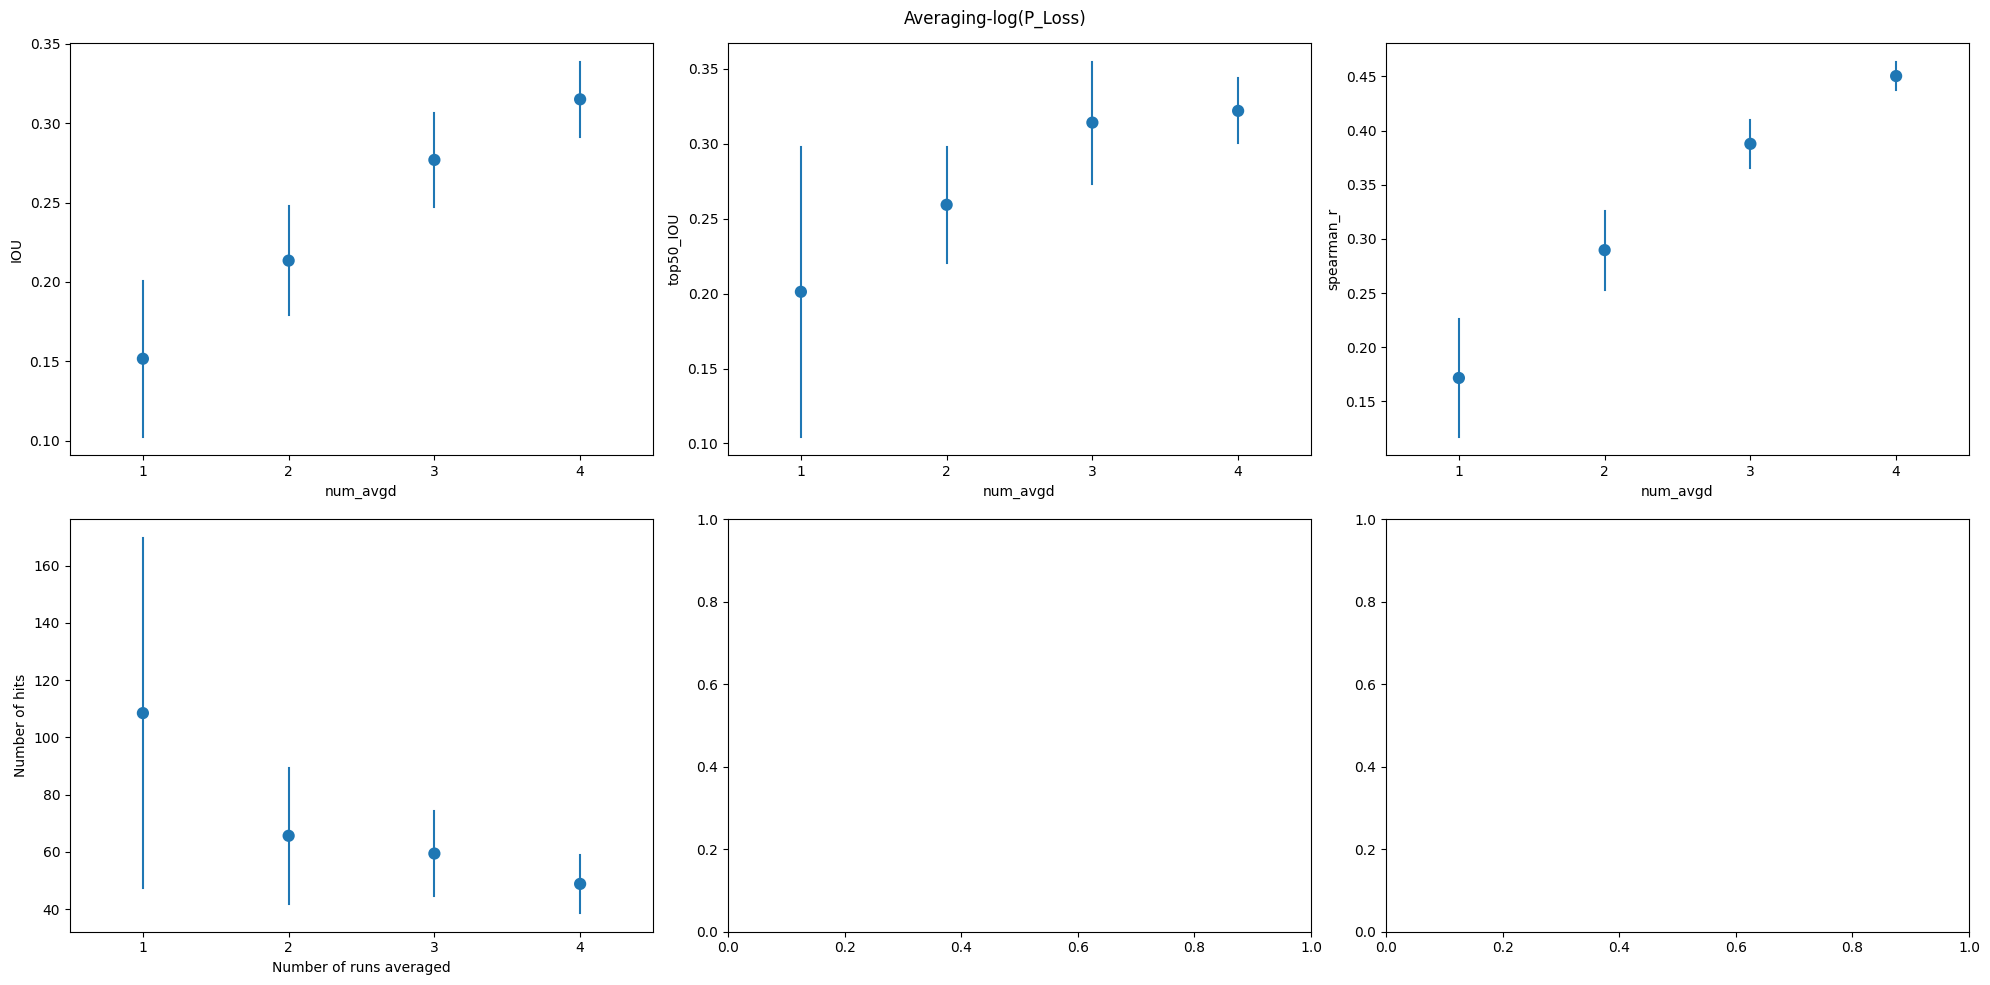

In [19]:
plot_df = pd.DataFrame(corr_dict)
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=False)
axes = axes.flatten()
for ax, c in zip(axes, ['IOU', 'top50_IOU', 'spearman_r']):
    sns.pointplot(data=plot_df, x='num_avgd', y=c, 
                  errorbar='sd', join=False, ax=ax, errwidth=1.5)

num_avgd = np.tile(plot_df['num_avgd'].values, 2)
hit_size = np.concatenate((plot_df['A'].values, plot_df['B'].values))
sns.pointplot(x=num_avgd, y=hit_size, join=False, errwidth=1.5, errorbar='sd', ax=axes[3])
axes[3].set_xlabel('Number of runs averaged')
axes[3].set_ylabel('Number of hits')
plot_title = f'Averaging-log(P_{metric})'
plt.gcf().suptitle(plot_title)
plt.tight_layout()
plt.savefig(f'./results_Sens8_v4_avg/{plot_title}.png')
plt.show()

#### Combined plots for averaging log(P_Acc) and log(P_Loss)

In [43]:
# Code to concatenate 2 the corr_dicts for Acc and Loss and add an additional
# key called 'metric' to identify the metric
with open('./results_Sens8_v4_avg/Sens8_p_avg_Acc_corr_dict.yaml', 'r') as f:
    corr_dict = yaml.load(f, Loader=yaml.FullLoader)
    corr_dict['metric'] = ['Acc']*len(corr_dict['spearman_r'])

with open('./results_Sens8_v4_avg/Sens8_p_avg_Loss_corr_dict.yaml', 'r') as f:
    corr_dict2 = yaml.load(f, Loader=yaml.FullLoader)
    corr_dict2['metric'] = ['Loss']*len(corr_dict2['spearman_r'])

for k in corr_dict.keys():
    corr_dict[k] += corr_dict2[k]


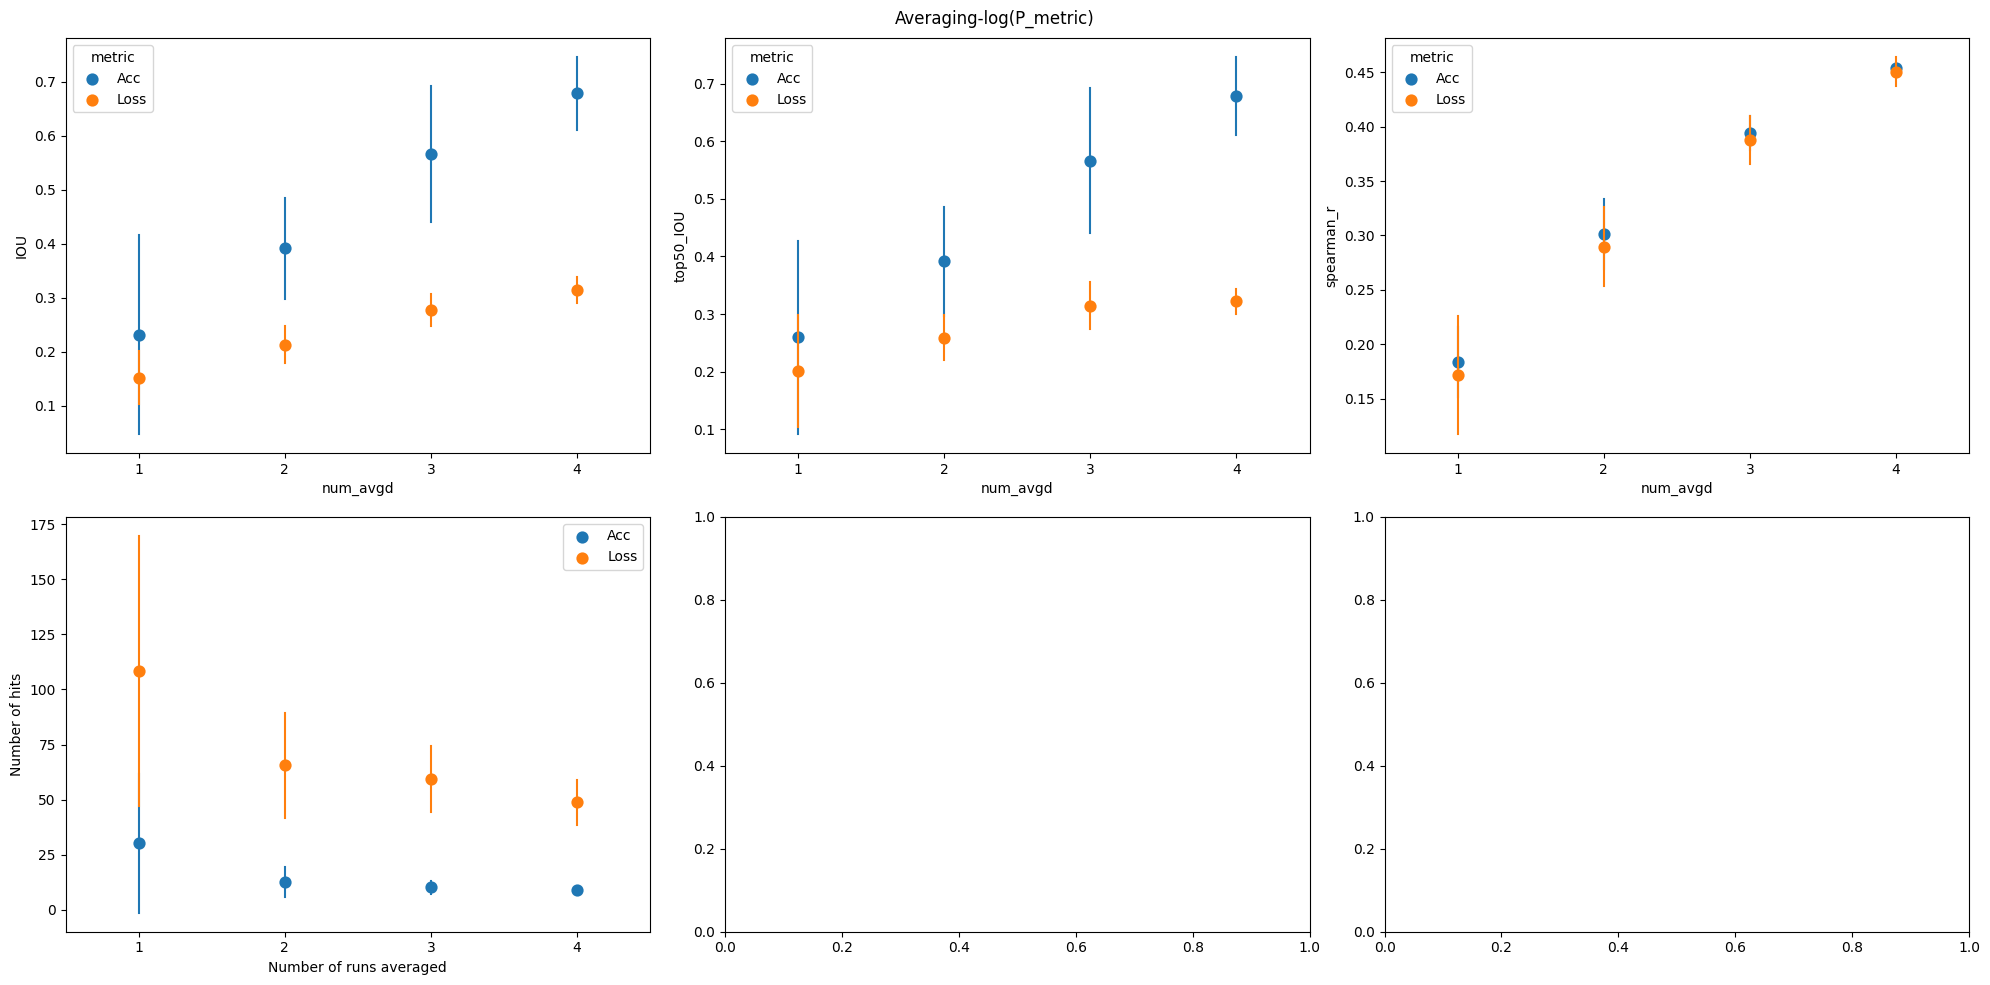

In [44]:
plot_df = pd.DataFrame(corr_dict)
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=False)
axes = axes.flatten()
for ax, c in zip(axes, ['IOU', 'top50_IOU', 'spearman_r']):
    sns.pointplot(data=plot_df, x='num_avgd', y=c, hue='metric',
                  errorbar='sd', join=False, ax=ax, errwidth=1.5)

num_avgd = np.tile(plot_df['num_avgd'].values, 2)
hit_size = np.concatenate((plot_df['A'].values, plot_df['B'].values))
hue = np.concatenate((plot_df['metric'].values, plot_df['metric'].values))
sns.pointplot(x=num_avgd, y=hit_size, hue=hue, join=False, errwidth=1.5, 
                errorbar='sd', ax=axes[3])
axes[3].set_xlabel('Number of runs averaged')
axes[3].set_ylabel('Number of hits')
plot_title = f'Averaging-log(P_metric)'
plt.gcf().suptitle(plot_title)
plt.tight_layout()
plt.savefig(f'./results_Sens8_v4_avg/{plot_title}.png')
plt.show()

### Hit overlap between individual runs

In [10]:
grp_sizes = [10]
tseeds = [0, 37, 89, 172, 281, 363, 937, 4250]
rseeds = tseeds
metric = 'Loss'
version = 'v4'

hit_dict = {}
for gs in grp_sizes:
    for tseed, rseed in zip(tseeds, rseeds):
        exp_name = f'Sens8_{tseed}{rseed}_GS{gs}_{version}'
        exp_folder = f'./results_{exp_name}'
        summ_df = pd.read_csv(f'{exp_folder}/FH_AD_{metric}_{exp_name}_summary.csv')
        _, corr_p, _, alpha_bonf = multipletests(summ_df['P'].values, method='bonferroni')
        summ_df[f'corr_p'] = corr_p
        hit_dict[f'seed:{tseed}'] = set(summ_df[summ_df['corr_p'] < 0.05]['Gene'].to_list())

In [18]:
# Get list of elements that appear in the values of atleast 2 keys in
# the hit_dict
from collections import Counter
counter = Counter()
for k, v in hit_dict.items():
    counter.update(v)

hit_genes = set([k for k, v in counter.items() if v >= 2])
hit_genes


{'ABCA7_1',
 'ACE_0',
 'ADAM10_3',
 'ADAM10_4',
 'AKR1C6P_3',
 'ANGEL2_0',
 'ANO6_0',
 'APH1B_0',
 'APOC1P1_0',
 'APOC1_0',
 'APOC4-APOC2_0',
 'APOE_0',
 'ATF6_10',
 'ATXN1_12',
 'BBS9_4',
 'BCAM_0',
 'BCAM_1',
 'BCL3_0',
 'BIN1_2',
 'BIN1_3',
 'BIN1_5',
 'BLOC1S3_0',
 'CACNA2D3_9',
 'CBLC_0',
 'CBLC_1',
 'CCDC13-AS1_0',
 'CCDC62_1',
 'CD1D_0',
 'CDH10_10',
 'CEACAM16_0',
 'CEACAM16_1',
 'CLPTM1_0',
 'CLPTM1_1',
 'CLPTM1_2',
 'COL4A1_11',
 'CTSH_1',
 'DLC1_44',
 'DLGAP1_53',
 'EPHA1-AS1_0',
 'EPHA1_0',
 'EPHA5_11',
 'EPHA5_13',
 'EPHA6_18',
 'EXOC3L2_0',
 'EXOC3L2_1',
 'EXOC3L2_2',
 'FSTL4_4',
 'GRHL2_6',
 'GRID1_45',
 'HIGD1C_2',
 'HIP1R_1',
 'HIP1R_2',
 'HKDC1_1',
 'HMG20A_0',
 'HMG20A_1',
 'HMGXB3_1',
 'HPSE2_8',
 'HSP90AB4P_0',
 'ITGBL1_1',
 'KATNAL2_2',
 'KRT82_0',
 'KRT84_0',
 'LINC00535_13',
 'LINC00597_0',
 'LINGO2_32',
 'LOC392364_1',
 'LOC400940_0',
 'LRRC7_2',
 'LRRC7_3',
 'LRRC7_4',
 'LRRC7_5',
 'LRRC7_7',
 'LRRC7_8',
 'LRRC7_9',
 'MAN1A1_13',
 'MAP2K1_0',
 'MCM6_1',
 'MYO5

## Architecture test for stability

In [89]:
tseeds = [0, 73, 347, 816]

metric = 'Loss'
greater_is_better = False
exp_types = ['', '_FrozenCov', '_GS10', '_GS10_FrozenCov', '_GS20', '_GS20_FrozenCov']
models = ['BranchedMLP', 'GWANNet5']

# metric = 'snp_grads'
# greater_is_better = True
# exp_types = ['_GS10', '_GS10_FrozenCov', '_GS20', '_GS20_FrozenCov']
# models = ['GWANNet5']

sign = 1 if greater_is_better else -1

comb_df = []
for et in exp_types:
    for m in models:
        for tseed in tseeds:
            if m == 'GWANNet5':
                exp_name = f'ArchTest_{tseed}{tseed}{et}'
            else:
                exp_name = f'ArchTest_{tseed}{et}'
            exp_folder = f'./results/results_{exp_name}_{m}'
            try:
                summ_df = pd.read_csv(f'{exp_folder}/FH_AD_{metric}_{exp_name}_summary.csv')
            except FileNotFoundError:
                continue
            
            summ_df['Exp'] = f'{m}{et}'
            summ_df['Seed'] = tseed
            summ_df[metric] = summ_df[metric]
            
            vals = summ_df['P'].values
            summ_df.loc[vals==0, 'P'] = np.min(vals[vals!=0]) * 1e-10
            
            summ_df['-log10(P)'] = -np.log10(summ_df['P'].values)
            
            comb_df.append(summ_df[['Gene', 'Chrom', 'Exp', 'Seed', 'P', '-log10(P)', metric]])

comb_df = pd.concat(comb_df)
comb_df


,Gene,Chrom,Exp,Seed,P,-log10(P),Loss
0,APOE_0,19,BranchedMLP,0,1.209834e-40,39.917274,0.682711
1,APH1B_0,15,BranchedMLP,0,2.984474e-02,1.525132,0.693883
2,ADAM10_3,15,BranchedMLP,0,1.439851e-02,1.841683,0.693530
3,ADAM10_2,15,BranchedMLP,0,5.715776e-03,2.242925,0.693145
4,BIN1_1,2,BranchedMLP,0,1.747087e-02,1.757685,0.693619
...,...,...,...,...,...,...,...
295,WWOX_128,16,GWANNet5_GS20_FrozenCov,816,3.485882e-01,0.457687,0.693590
296,WWOX_117,16,GWANNet5_GS20_FrozenCov,816,3.770743e-01,0.423573,0.693681
297,WWOX_127,16,GWANNet5_GS20_FrozenCov,816,3.669911e-01,0.435344,0.693648
298,WWOX_121,16,GWANNet5_GS20_FrozenCov,816,9.989005e-01,0.000478,0.699487


In [90]:
from itertools import combinations
seed_combs = list(combinations(comb_df['Seed'].unique(), 2))

metric_diff_df = []
for exp in comb_df['Exp'].unique():
    tdf = comb_df[comb_df['Exp'] == exp].copy()
    for seed_pair in seed_combs:
        a = tdf.loc[tdf['Seed'] == seed_pair[0]][['Gene', 'Chrom', metric]]
        b = tdf.loc[tdf['Seed'] == seed_pair[1]][['Gene', 'Chrom', metric]]
        a.sort_values(['Gene', 'Chrom'], inplace=True)
        b.sort_values(['Gene', 'Chrom'], inplace=True)

        assert a['Gene'].values.tolist() == b['Gene'].values.tolist(), f"{a['Gene'].values.tolist()}\n\n{b['Gene'].values.tolist()}"

        metric_diff = np.abs(a[metric].values - b[metric].values)
        diff_df = pd.DataFrame(columns=['Gene', 'Chrom', 'Exp', 'Seed1', 'Seed2', 'Metric_diff'])
        diff_df['Gene'] = a['Gene'].values
        diff_df['Chrom'] = a['Chrom'].values
        diff_df['Exp'] = exp
        diff_df['Seed_pair'] = f'{seed_pair[0]} vs {seed_pair[1]}'
        diff_df['Metric_diff'] = metric_diff
        metric_diff_df.append(diff_df)

metric_diff_df = pd.concat(metric_diff_df)
metric_diff_df['Exp'].unique()


array(['BranchedMLP', 'BranchedMLP_FrozenCov', 'GWANNet5_GS10',
       'GWANNet5_GS10_FrozenCov', 'GWANNet5_GS20',
       'GWANNet5_GS20_FrozenCov'], dtype=object)

### Difference between metric values for different architectures
* **x-axis**: Architecture type
* **color**: Random seed or pair of random seeds

- Top
  - **y-axis**: Distribution of absolute metric difference between pairs of random
  seeds for all tested gene windows
- Middle
  - **y-axis**: Distribution of metric for all random seeds for all tested gene windows
- Bottom
  - **y-axis**: Distribution of -log10(P) for all random seeds for all tested gene windows

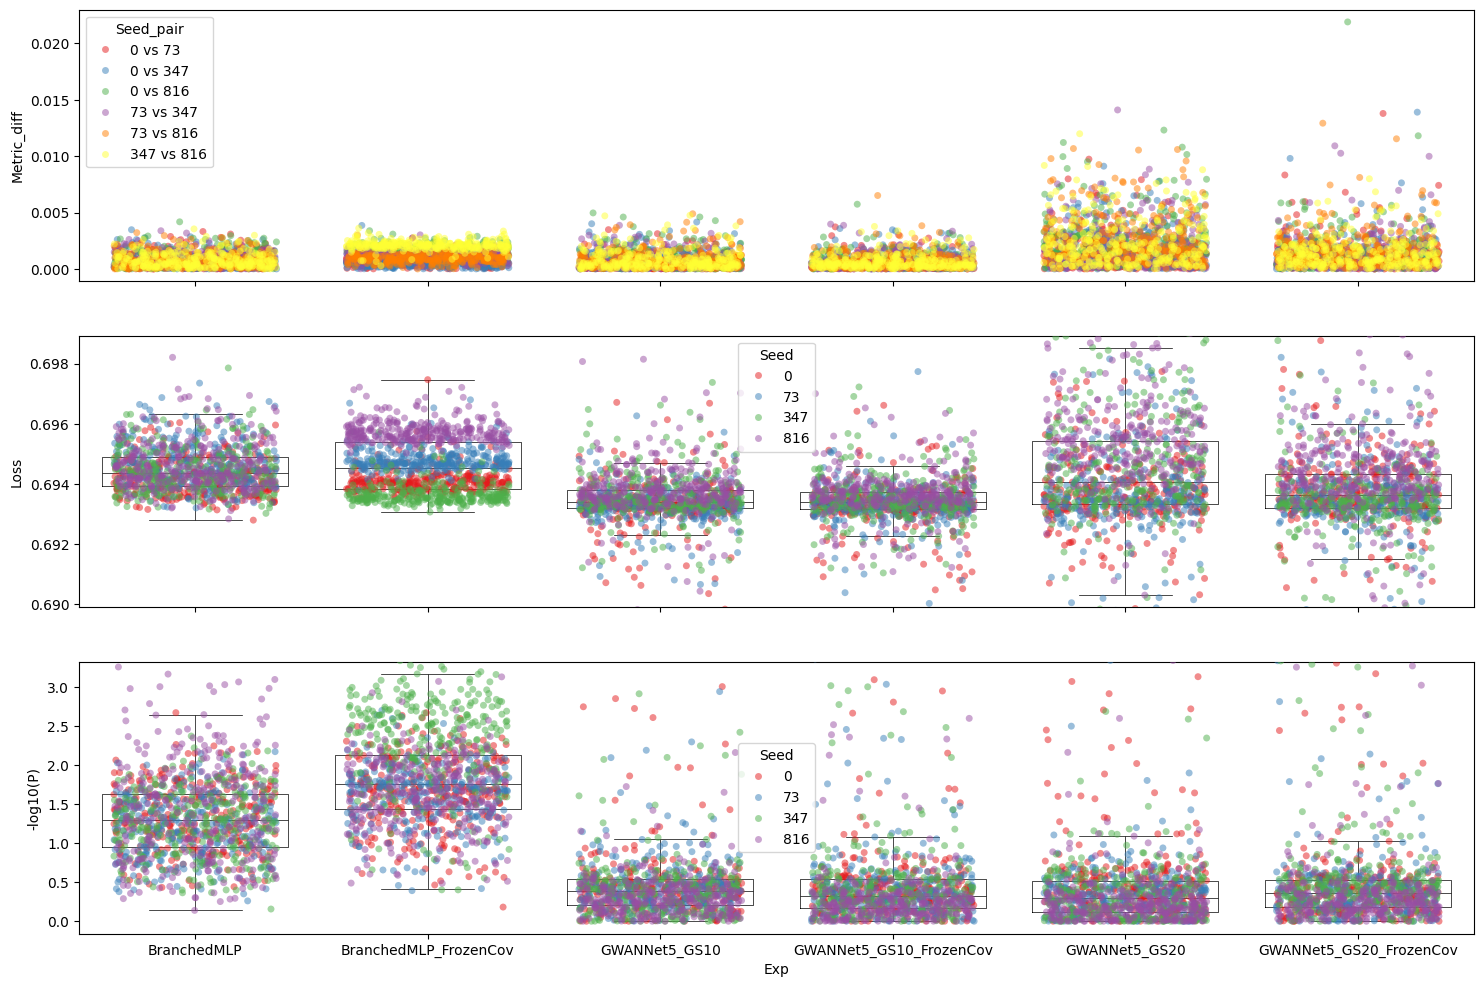

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(18, 12), sharex=True)
ax = ax.flatten()

sns.stripplot(data=metric_diff_df, x='Exp', y='Metric_diff', hue='Seed_pair', 
              ax=ax[0], alpha=0.5, palette='Set1', jitter=0.35)

sns.boxplot(data=comb_df, x='Exp', y=metric, ax=ax[1], showfliers=False, fill=False,
            color='black', linewidth=0.5,)
ylims = ax[1].get_ylim()
sns.stripplot(data=comb_df, x='Exp', y=metric, hue='Seed', ax=ax[1], 
              alpha=0.5, palette='Set1', jitter=0.35)
ax[1].set(ylim=ylims);

sns.boxplot(data=comb_df, x='Exp', y='-log10(P)', ax=ax[2], showfliers=False, fill=False,
            color='black', linewidth=0.5,)
ylims = ax[2].get_ylim()
sns.stripplot(data=comb_df, x='Exp', y='-log10(P)', hue='Seed', ax=ax[2], 
              alpha=0.5, palette='Set1', jitter=0.35)
ax[2].set(ylim=ylims);


### Difference in metric value for different architectures and random seeds

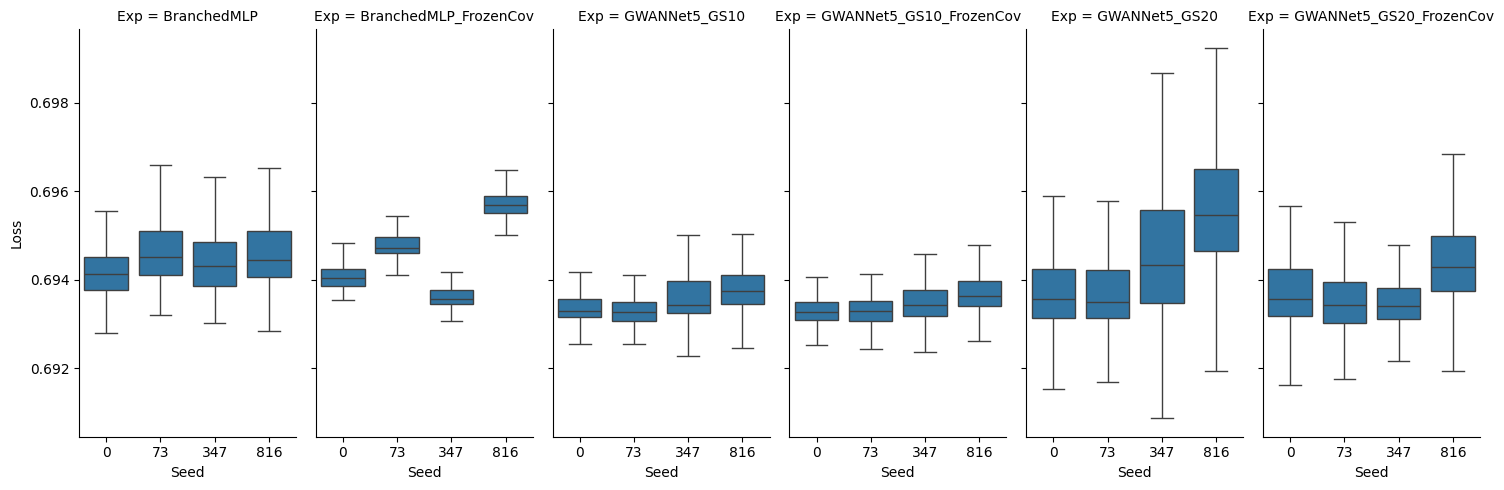

In [18]:
fg = sns.FacetGrid(data=comb_df, col='Exp', sharey=True, height=5, aspect=0.5)
fg.map_dataframe(sns.boxplot, data=comb_df, x='Seed', y=metric, ax=ax[1], 
                 showfliers=False)

### Difference in -log10(p) value for different architectures and random seeds

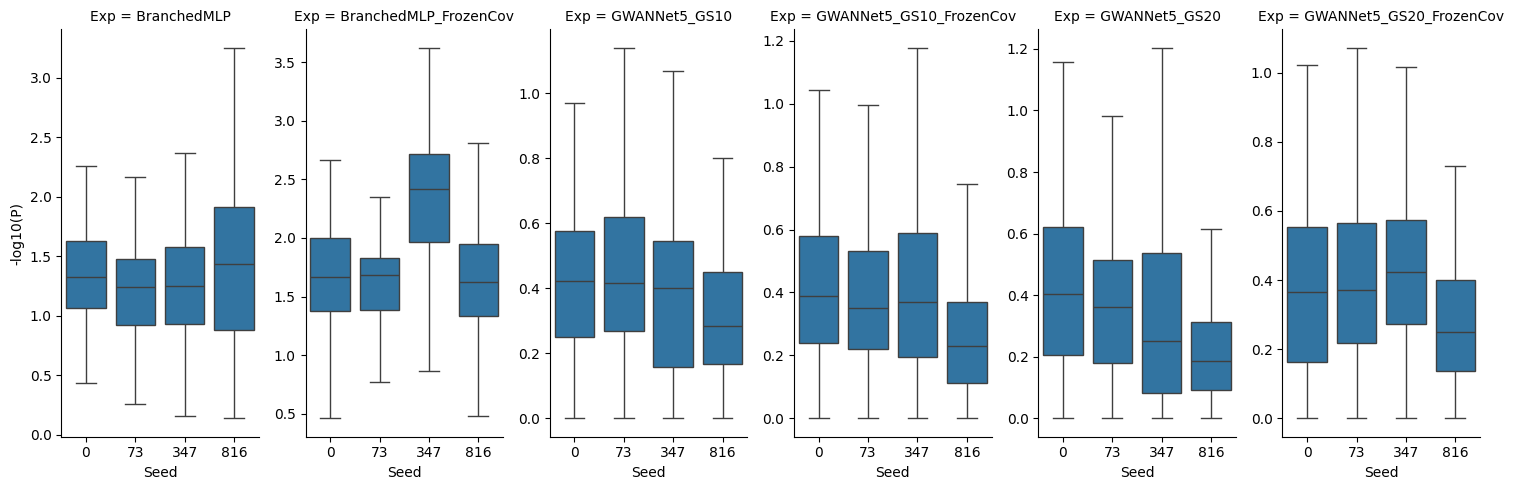

In [19]:
fg = sns.FacetGrid(data=comb_df, col='Exp', sharey=False, height=5, aspect=0.5)
fg.map_dataframe(sns.boxplot, data=comb_df, x='Seed', y='-log10(P)', ax=ax[1], 
                 showfliers=False)

### Correlation between architectures and seeds

In [91]:
# Group by [Exp, Seed] and get the correlation between the metrics for
# all pairs of groups

exp_groups = comb_df.groupby(['Exp', 'Seed'])
grp_pairs = list(combinations(exp_groups.groups.keys(), 2))

correlation_list = []
for grps in grp_pairs:
    a = exp_groups.get_group(grps[0]).copy()
    b = exp_groups.get_group(grps[1]).copy()

    a.sort_values(['Gene'], inplace=True)
    b.sort_values(['Gene'], inplace=True)

    assert a['Gene'].values.tolist() == b['Gene'].values.tolist(), f"{a['Gene'].values.tolist()}\n\n{b['Gene'].values.tolist()}"

    rho, p = spearmanr(a[metric].values, b[metric].values)

    a = a.loc[a['P'] < (0.05/70000)]
    b = b.loc[b['P'] < (0.05/70000)]
    i = len(set(a['Gene'].values).intersection(set(b['Gene'].values)))

    correlation_list.append(
        [f"{grps[0][0]}-{grps[0][1]} ({len(a)})", 
         f"{grps[1][0]}-{grps[1][1]} ({len(b)})", 
         i])
    correlation_list.append(
        [f"{grps[1][0]}-{grps[1][1]} ({len(b)})",
         f"{grps[0][0]}-{grps[0][1]} ({len(a)})", 
         i])

for exp in set([c[0] for c in correlation_list]):
    correlation_list.append([exp, exp, np.nan])
print(len(exp_groups.groups.keys()))

24


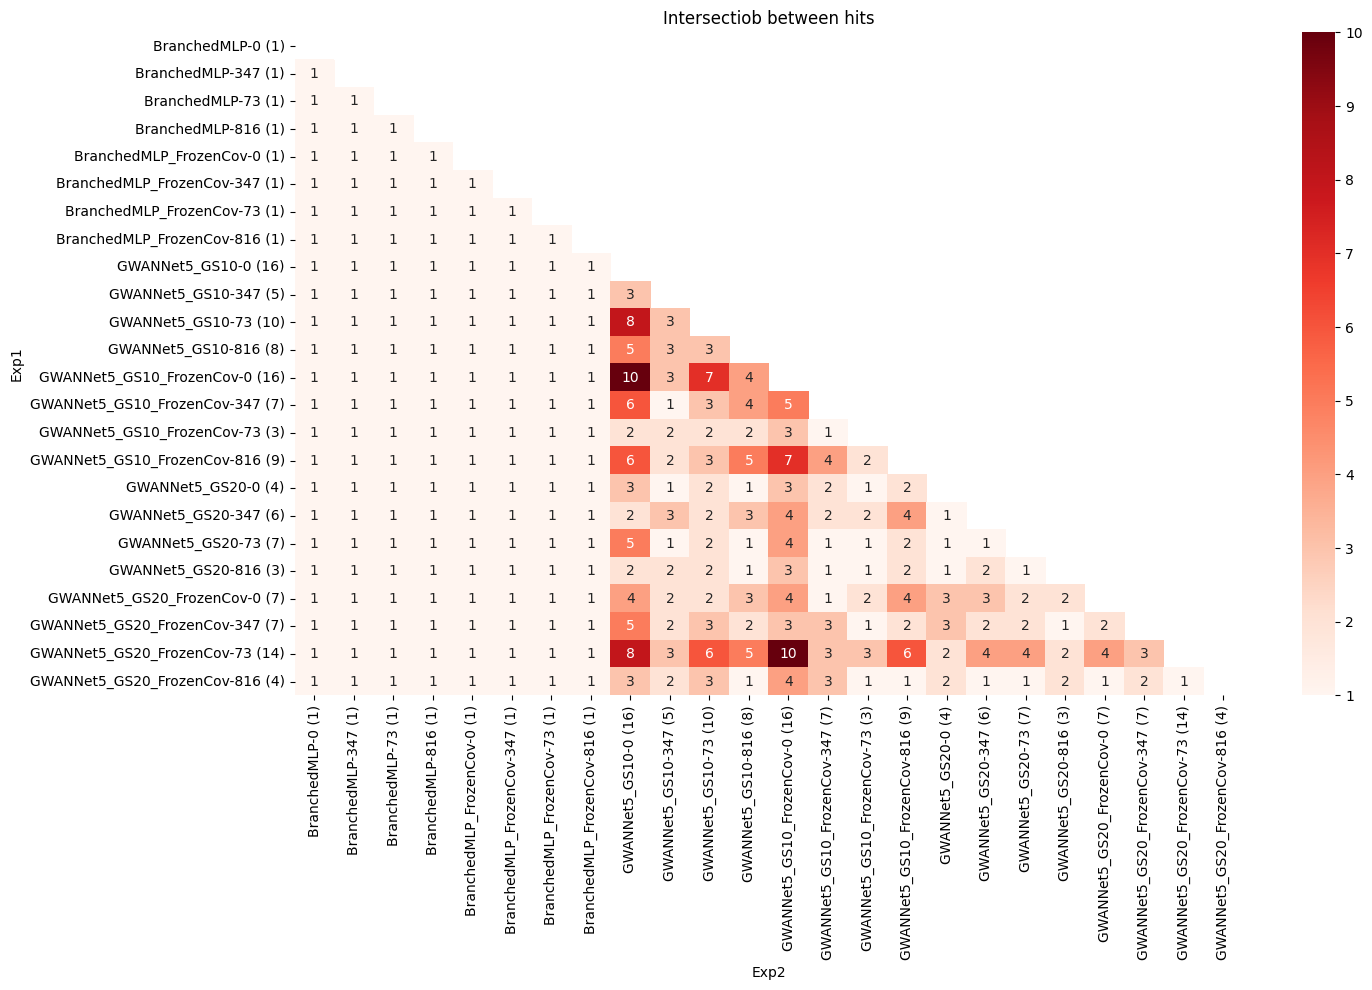

In [92]:
corr_df = pd.DataFrame.from_records(correlation_list, columns=['Exp1', 'Exp2', 'rho'])
corr_df = corr_df.pivot(index='Exp1', columns='Exp2', values='rho')

# Set upper trianlgular to nan
mask = np.zeros_like(corr_df, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr_df = corr_df.mask(mask)

# plot the correlation matrix as a heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr_df, annot=True, ax=ax, cmap='Reds')
# ax.set_title('Correlation between Loss')
ax.set_title('Intersectiob between hits')
plt.tight_layout()
plt.savefig('hit_intersection.png')
